<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/6hours_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airqino table Data
Average data values (every 6 hours) of every month since July to predict the last 18 days of the selected data

In [ ]:
import pandas as pd
import psycopg2
import pytz
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('6 hour', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-06-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-12-10 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
europe = pytz.timezone('Europe/Rome')
df.index = df.index.tz_localize(pytz.utc).tz_convert(europe)
#make the dates a string
df.reset_index(level=0, inplace=True)
for i in range(len(df)):
  df['Dates'][i]=df['Dates'][i].strftime('%Y-%m-%d %H')
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)
df=df.dropna()


display(df)

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-29 08,457.703704,1.296296,410.481481,43.327778,29.644444,6.037037,404.148148,244.000000,216.629630,375.481481
2021-06-29 14,523.896175,1.218579,408.027322,46.536011,32.412022,6.737705,384.519126,253.109290,226.464481,404.349727
2021-06-29 20,452.995327,1.238318,407.990654,42.546636,28.035047,6.032710,490.635514,249.331776,226.074766,376.369159
2021-06-30 02,391.943723,1.943723,410.969697,38.649913,23.567965,8.251082,636.030303,259.796537,228.363636,349.277056
2021-06-30 08,414.850877,1.890351,406.438596,41.504825,26.664474,10.688596,487.500000,278.307018,219.114035,364.780702
...,...,...,...,...,...,...,...,...,...,...
2021-12-08 19,587.514894,99.782979,491.906383,18.630894,5.730213,163.514894,999.000000,292.680851,251.502128,362.740426
2021-12-09 01,400.914163,66.433476,450.150215,18.057897,5.192704,182.957082,999.000000,184.836910,232.240343,303.982833
2021-12-09 07,268.345992,5.371308,444.890295,18.001477,5.412658,6.637131,966.894515,120.046414,224.987342,293.683544


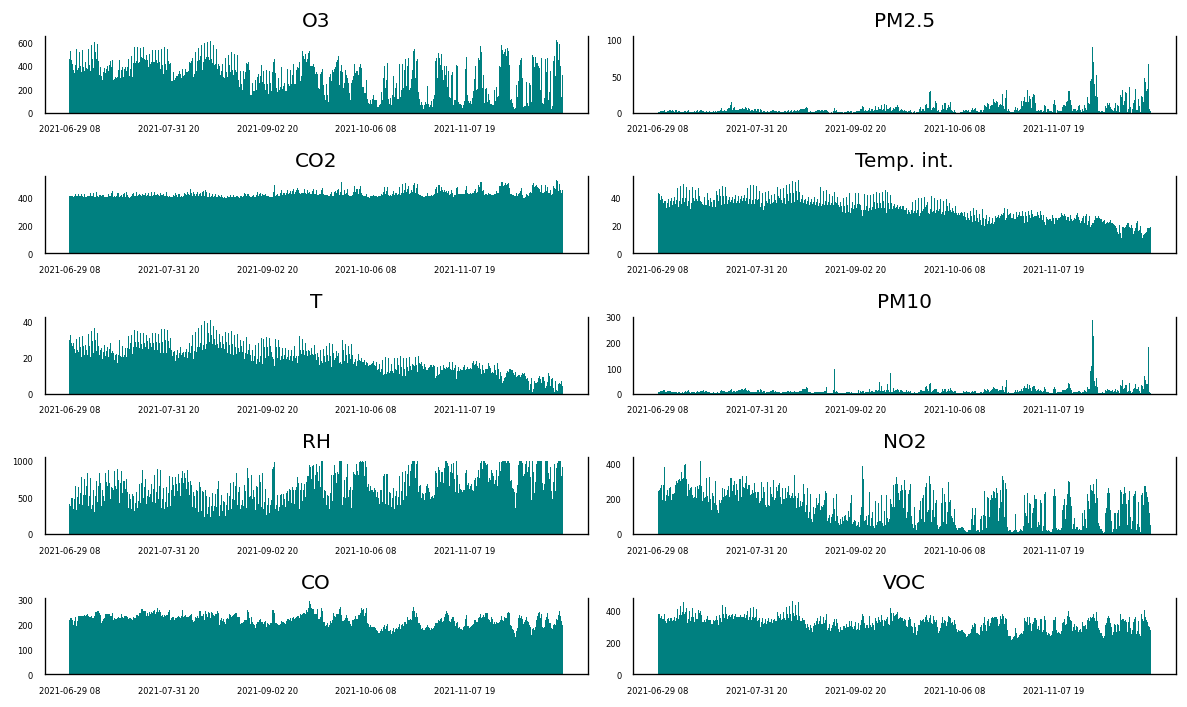

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
x_ticks = np.arange(0, len(df), 130)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.bar(data.index, data, color='teal', align='edge', width=1.0)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=5)
    ax.set_xticks(x_ticks)


plt.tight_layout();

# Wind data

Add the wind

,Wind
Date,
2021-06-29 08,1.17917
2021-06-29 14,2.825
2021-06-29 20,1.00417
2021-06-30 02,0.808333
2021-06-30 08,3.375
...,...
2021-12-08 19,0.745833
2021-12-09 01,0.833333
2021-12-09 07,1.47083


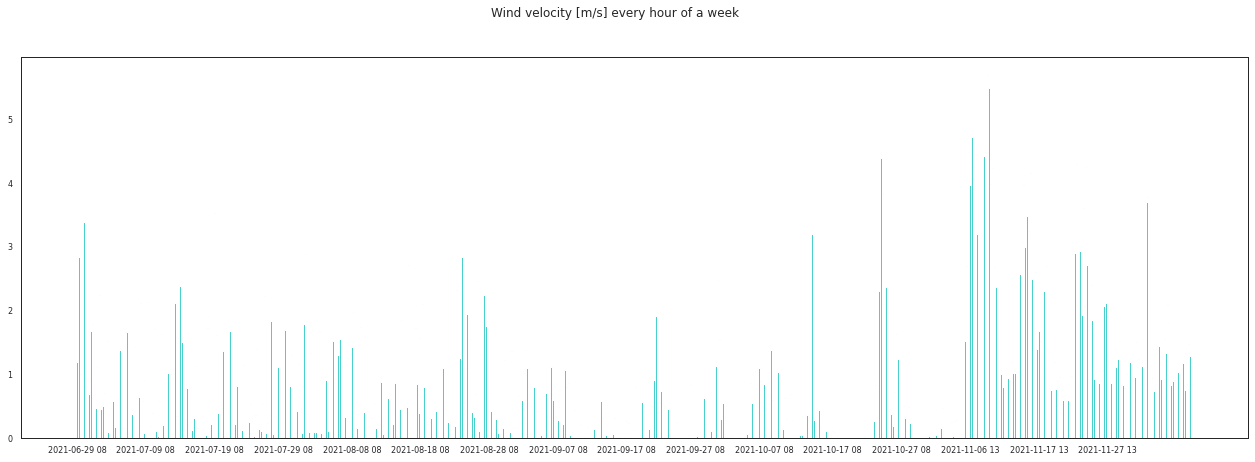

<Figure size 432x288 with 0 Axes>

In [ ]:
wind_temp = pd.read_csv('https://raw.githubusercontent.com/marcochisci/Anomaly_detection/main/anemo.csv')
wind_temp=wind_temp.set_index('Date')
wind_temp=wind_temp.loc['2021-06-29 08:00':'2021-12-10 06:00']
#togliere i valori tra '2021-10-31 02:00':'2021-10-31 07:00' poichè non utilizzabili dato il fuso orario
wind_temp=wind_temp.drop(['2021-10-31 02:00', '2021-10-31 02:15', '2021-10-31 02:30',
       '2021-10-31 02:45', '2021-10-31 03:00', '2021-10-31 03:15',
       '2021-10-31 03:30', '2021-10-31 03:45', '2021-10-31 04:00',
       '2021-10-31 04:15', '2021-10-31 04:30', '2021-10-31 04:45',
       '2021-10-31 05:00', '2021-10-31 05:15', '2021-10-31 05:30',
       '2021-10-31 05:45', '2021-10-31 06:00', '2021-10-31 06:15',
       '2021-10-31 06:30', '2021-10-31 06:45'])
wind_temp.reset_index(level=0, inplace=True)
wind_temp=wind_temp.drop([' Potenza'], axis=1)
#ogni 6 ore fa la media, 24 valori (ogni 15 minuti 1 valore)
num_values=24
how_many=int(len(wind_temp)/num_values)
wind_df=pd.DataFrame(columns=wind_temp.columns)
for i in range(how_many):
  value=0
  for j in range(num_values):
    value=value+wind_temp[' Velocità [m/s]'][i*num_values+j]
  value=value/num_values
  wind_df.loc[i,:]=[wind_temp['Date'][i*num_values],value]
#cambia formato delle date
for i in range(len(wind_df)):
  wind_df['Date'][i]=datetime.datetime.strptime(wind_df['Date'][i], "%Y-%m-%d %H:%M").strftime('%Y-%m-%d %H')
wind_df=wind_df.set_index('Date')
wind_df= wind_df.rename(columns={' Velocità [m/s]': 'Wind'})
display(wind_df)

# Plot
data_wind=wind_df['Wind']
plt.figure(figsize=(22, 7))
plt.bar(wind_df.index, data_wind, color='mediumturquoise', linewidth=1)
# Decorations
x_ticks = np.arange(0, 613, 40)
plt.xticks(x_ticks)
plt.tick_params(labelsize=8)
plt.suptitle('Wind velocity [m/s] every hour of a week')
plt.show()

plt.tight_layout();


Join the dataframes together, only get the rows that have all the values

In [ ]:
df=df.join(wind_df, how='outer')
df=df.dropna()
#there are two index here
display(df)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 08,457.703704,1.296296,410.481481,43.327778,29.644444,6.037037,404.148148,244.000000,216.629630,375.481481,1.17917
2021-06-29 14,523.896175,1.218579,408.027322,46.536011,32.412022,6.737705,384.519126,253.109290,226.464481,404.349727,2.825
2021-06-29 20,452.995327,1.238318,407.990654,42.546636,28.035047,6.032710,490.635514,249.331776,226.074766,376.369159,1.00417
2021-06-30 02,391.943723,1.943723,410.969697,38.649913,23.567965,8.251082,636.030303,259.796537,228.363636,349.277056,0.808333
2021-06-30 08,414.850877,1.890351,406.438596,41.504825,26.664474,10.688596,487.500000,278.307018,219.114035,364.780702,3.375
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 19,587.514894,99.782979,491.906383,18.630894,5.730213,163.514894,999.000000,292.680851,251.502128,362.740426,0.745833
2021-12-09 01,400.914163,66.433476,450.150215,18.057897,5.192704,182.957082,999.000000,184.836910,232.240343,303.982833,0.833333
2021-12-09 07,268.345992,5.371308,444.890295,18.001477,5.412658,6.637131,966.894515,120.046414,224.987342,293.683544,1.47083
2021-12-09 13,135.400844,1.945148,427.383966,18.712363,6.756540,2.670886,791.696203,50.810127,213.067511,277.194093,1.28333


# Preparations

In [ ]:
df_copy= df.copy()

In [ ]:
pip install fitter

     |████████████████████████████████| 47 kB 3.5 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25026 sha256=64c3a463eaeed5f9c4b4b711e64440784ce2763d3897903e34e75a0ca6d5980f
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=32877e9d5e922542f19105c2a47660bab93c0528f60d44518dd8a9d1b9493492
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


# VAR model mahalanobis

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 12
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

7


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Calculating the errors

In [ ]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_summarymaha=str(var_fitresults.summary())
print(var_summarymaha[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag:], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[selected_lag:], columns={"errors"})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jan, 2022
Time:                     16:43:52
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    46.7237
Nobs:                     642.000    HQIC:                   43.7024
Log likelihood:          -21813.0    FPE:                1.41730e+18
AIC:                      41.7862    Det(Omega_mle):     4.96497e+17
--------------------------------------------------------------------



# Testing the mahalanobis errors' distribution and finding the thresholds

Make a histogram

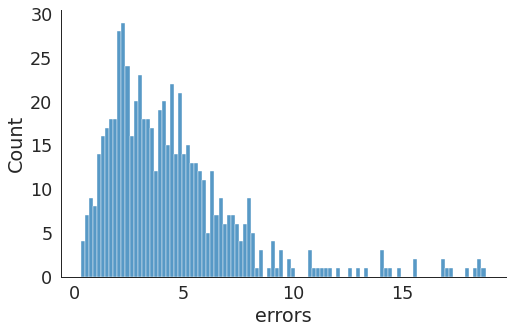

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
#remove outliers
z_scores = stats.zscore(errors_df)

abs_z_scores = np.abs(z_scores)
filtered_errors = (abs_z_scores < 3).all(axis=1)
new_errors_df = errors_df[filtered_errors]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=new_errors_df, x="errors", kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error         aic          bic  kl_div
invgauss         0.036329  801.750303 -6162.285446     inf
lognorm          0.036451  801.734500 -6160.164812     inf
beta             0.036765  820.037095 -6148.269608     inf
gamma            0.036975  816.390699 -6151.119788     inf
pearson3         0.036976  816.394327 -6151.101049     inf


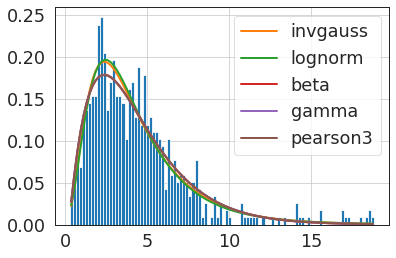

In [ ]:
er = new_errors_df["errors"].values
er_min=min(er)
er_max=max(er)
f = Fitter(er,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param=f.fitted_param[distribution]

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang

#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

threshold low: 12.157645997112937
threshold med: 14.792987461656924
threshold high: 16.811546881307642


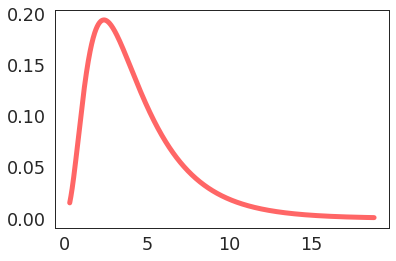

In [ ]:
from scipy.stats import invgauss
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

low, med, high= 0.975, 0.99, 0.995
find= np.linspace(er_min+((er_max-er_min)/1000),er_max*2, 2000)
x = np.linspace(er_min+((er_max-er_min)/1000),er_max, 1000)
dis=distributions[distribution]
num_var=get_num_var(distribution)
if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
#1 variables
if(num_var==1):
  c= param[0]
  loc, scale = param[1], param[2]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)
  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):        
      threshold_l=i
      found=1
    if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
#3 variables
if(num_var==2):
  c,d= param[0], param[1]
  loc, scale = param[2], param[3]
  #graph to test if the parameters are correct
  ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

  # using the cdf
  found=0
  for i in find:
    if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
      threshold_l=i
      found=1
    if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
      threshold_m=i
      found=2
    if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
      threshold_h=i
      found=3
print('threshold low: '+str(threshold_l))
print('threshold med: '+str(threshold_m))
print('threshold high: '+str(threshold_h))

# Finding anomalies with mahalanobis distance

In [ ]:
#0 means that is it not an anomaly
def find_anomalies(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i].values >= threshold_low) &(errors.iloc[i].values < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i].values >= threshold_med) &(errors.iloc[i].values < threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i].values >= threshold_high):
      predictions.iloc[i]=3
  return predictions

predictions = find_anomalies(abs(errors_df),threshold_l, threshold_m, threshold_h)

Select how many values do you want to predict: there are 4 values each day.

If you want to find the anomalies of the first 18 days of November hom_many should be set at 72

In [ ]:
data = df_copy.iloc[selected_lag: , :]
data['Predictions'] = predictions.values
how_many=72
data=data.iloc[-how_many:,:]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-11-22 01,524.832618,56.815451,498.733906,23.483391,11.685837,68.888412,999.000000,305.811159,250.317597,355.111588,0.0
2021-11-22 07,409.279661,21.364407,463.211864,25.215381,13.388559,26.779661,968.067797,203.076271,246.923729,335.152542,3.0
2021-11-22 13,183.186441,2.326271,426.991525,27.137161,15.263559,3.576271,725.190678,62.593220,206.940678,290.754237,2.0
2021-11-22 19,110.137339,2.716738,426.253219,25.397039,13.636910,3.463519,729.244635,42.957082,197.424893,273.969957,0.0
2021-11-23 01,116.030702,2.451754,425.438596,24.882632,12.946053,3.381579,738.421053,49.837719,194.456140,271.228070,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 19,587.514894,99.782979,491.906383,18.630894,5.730213,163.514894,999.000000,292.680851,251.502128,362.740426,3.0
2021-12-09 01,400.914163,66.433476,450.150215,18.057897,5.192704,182.957082,999.000000,184.836910,232.240343,303.982833,3.0
2021-12-09 07,268.345992,5.371308,444.890295,18.001477,5.412658,6.637131,966.894515,120.046414,224.987342,293.683544,3.0


In [ ]:
data['Predictions'].value_counts()

0.0    58
3.0     8
1.0     3
2.0     3
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance with graphs

get all the anomalies

In [ ]:
anomalies_l= data[(data['Predictions'] == 1)]
anomalies_m= data[(data['Predictions'] == 2)]
anomalies_h= data[(data['Predictions'] == 3)]

Get the day before to compare

In [ ]:
day_before= df_copy.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError

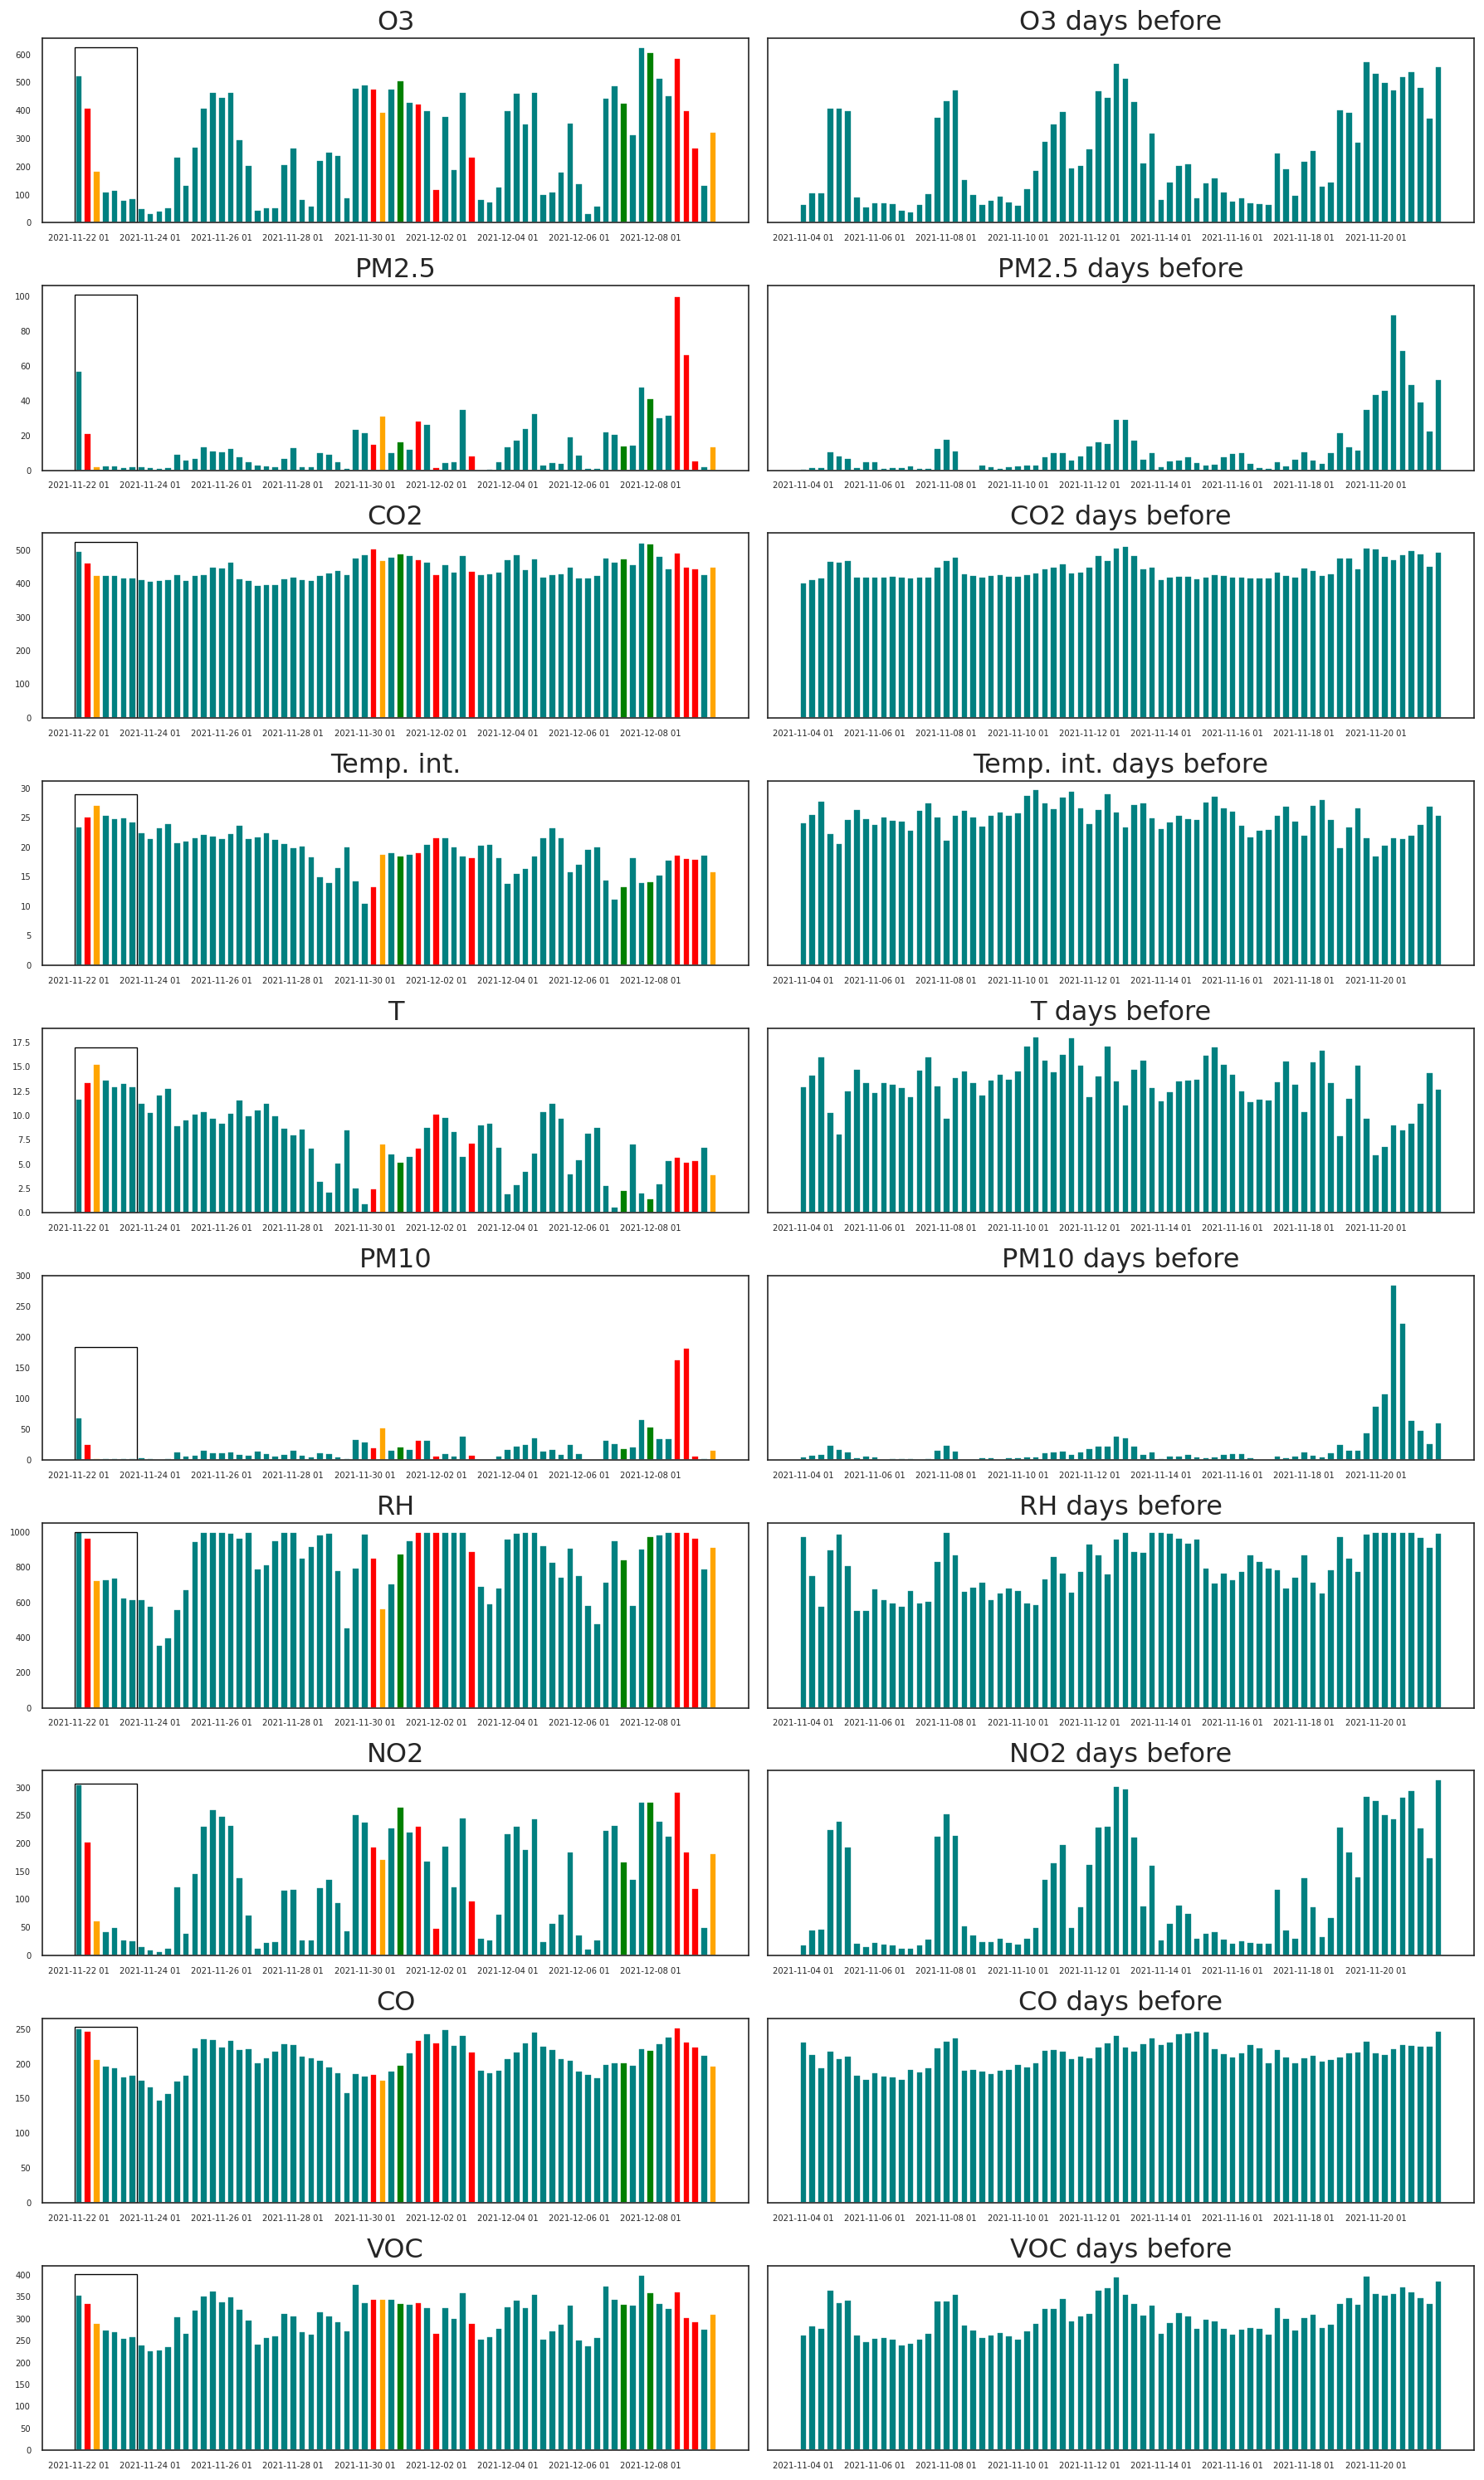

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib
%matplotlib inline

num_col=len(df_copy.columns)
# Plot
fig, axes = plt.subplots(nrows=num_col, ncols=2, sharey='row', dpi=120, figsize=(15,25))
x_ticks = np.arange(0, how_many, 8)
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = data[df.columns[i/2]]
      ax.bar(data_maha.index, data_maha, color='teal', linewidth=1)
      ax.set_xticks(x_ticks)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green',  linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange',  linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag, int(max(data[df.columns[i/2]])+2))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' days before')
      ax.tick_params(labelsize=6)
      ax.set_xticks(x_ticks)

plt.tight_layout();

# Searching the anomalies using the euclidian distance for each variable

Testing stationarity

In [ ]:
df_e=df_copy.copy()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_e, col)
    for col in df_e.columns
}
adf_test_results     

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing.

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df_e.columns:
    df_e[col] = differencing(df_e, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 40
var_model = VAR(df_e)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag_eucl = lag_results.aic
print(selected_lag_eucl)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


40


In [ ]:
import numpy as np
import scipy as sp

#euclidian distance
def euclidian(x=None, data=None):
  distance = pd.DataFrame(index=df_copy.index[selected_lag_eucl:], columns=data.columns)
  for col in data.columns:
    distance[col]=abs((x[col]).values-(data[col]).values)
  return distance
var = VAR(df_e)
var_fitresults = var.fit(selected_lag_eucl)
var_summaryeucl=str(var_fitresults.summary())
print(var_summaryeucl[0:624])
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag_eucl:], columns=df_e.columns)
distance = euclidian(x=var_fit_df, data= df_e.iloc[selected_lag_eucl:])
display(distance)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jan, 2022
Time:                     16:44:08
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    70.5944
Nobs:                     609.000    HQIC:                   52.8455
Log likelihood:          -17281.6    FPE:                1.53414e+19
AIC:                      41.5445    Det(Omega_mle):     9.74597e+16
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-07-09 08,3.564278,0.168779,0.930825,0.000843,0.075492,1.234993,5.400925,14.417187,1.012093,0.813444
2021-07-09 14,13.699526,0.859488,5.236786,0.767498,1.084170,0.861901,51.055285,3.129442,1.426750,7.354626
2021-07-09 20,13.639186,2.944908,1.831837,0.180311,0.209840,9.432693,19.267297,17.729553,4.189306,5.775473
2021-07-10 02,19.484726,2.534280,4.537300,0.777253,1.003109,7.495557,17.209601,19.934120,1.007818,3.127958
2021-07-10 08,18.244145,3.762698,6.502112,0.326113,0.236627,3.355340,17.460579,0.944683,1.483994,3.178253
...,...,...,...,...,...,...,...,...,...,...
2021-12-08 19,21.399502,12.503984,9.734451,0.416059,0.568734,18.571654,39.042002,28.773225,1.651000,4.594830
2021-12-09 01,23.471955,1.420803,7.097057,0.348994,0.360047,2.706940,15.210713,6.502216,3.872680,2.172828
2021-12-09 07,8.159169,2.711803,5.740337,0.472511,0.515092,8.701211,8.966789,8.863052,2.014422,2.505340


# Distributions function code

In [ ]:
from scipy.stats import burr, beta, expon, norm, uniform, weibull_min, weibull_max, invgauss, gamma, lognorm, pearson3, triang
import matplotlib.pyplot as plt



Get how many variables the distribution needs to work correctly

In [ ]:
def get_num_var(distribution):
  if(distribution=='burr' or distribution=='beta'):
    num_var=2
  if(distribution=='invgauss' or distribution=='gamma' or distribution=='weibull_min' or distribution=='weibull_max' or distribution=='lognorm'
         or distribution=='pearson3' or distribution=='triang' ):
    num_var=1
  if(distribution=='expon' or distribution=='norm' or distribution=='uniform' ):
    num_var=0
  return num_var

In [ ]:
#distributions, convert from string to dis
distributions={"burr": burr, "beta": beta, "invgauss": invgauss, "gamma": gamma, "weibull_min": weibull_min, "weibull_max": weibull_max,
               "lognorm": lognorm, "pearson3": pearson3, "triang": triang, "expon": expon, "norm": norm, "uniform": uniform}

Function used to get the thresholds

In [ ]:
def get_thresholds(dis, param, min, max,num_var):
  low, med, high= 0.90,0.95,0.99
  find= np.linspace(min+((max-min)/1000),max*2, 2000)
  x = np.linspace(min+((max-min)/1000),max, 1000)
  fig, ax = plt.subplots(1, 1)
  #0 variables
  if(num_var==0):
    loc, scale = param[0], param[1]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #1 variables
  if(num_var==1):
    c= param[0]
    loc, scale = param[1], param[2]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i, c,loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  #3 variables
  if(num_var==2):
    c,d= param[0], param[1]
    loc, scale = param[2], param[3]
    #graph to test if the parameters are correct
    ax.plot(x, dis.pdf(x,c,d, loc, scale),
       'r-', lw=5, alpha=0.6)

    # using the cdf
    found=0
    for i in find:
      if ((dis.cdf(i,c,d, loc, scale)>low) & (found<1)):
        threshold_l=i
        found=1
      if ((dis.cdf(i,c,d, loc, scale)>med) & (found<2)):
        threshold_m=i
        found=2
      if ((dis.cdf(i,c,d, loc, scale)>high) & (found<3)):
        threshold_h=i
        found=3
  return threshold_l, threshold_m, threshold_h

# Testing the distance's distributions and finding the thresholds

Make histograms

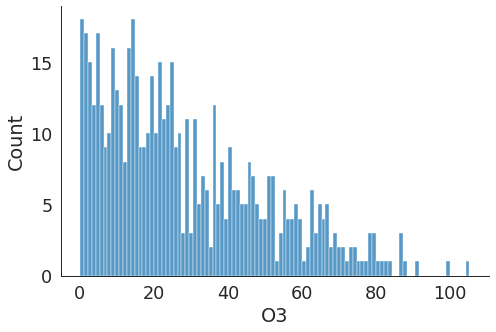

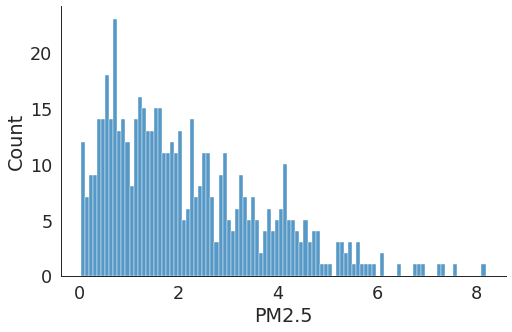

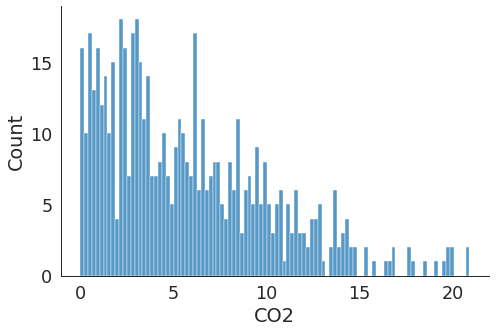

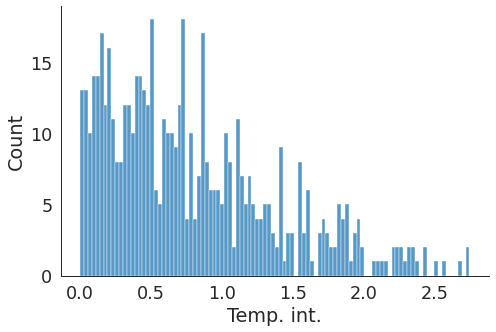

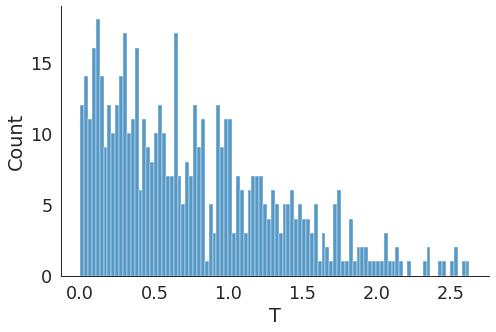

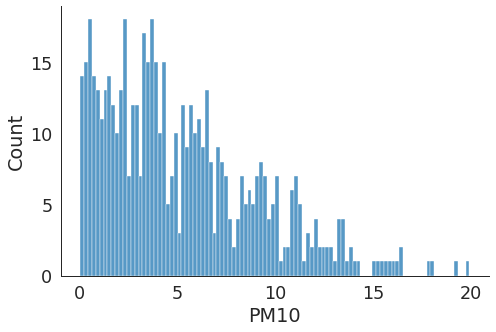

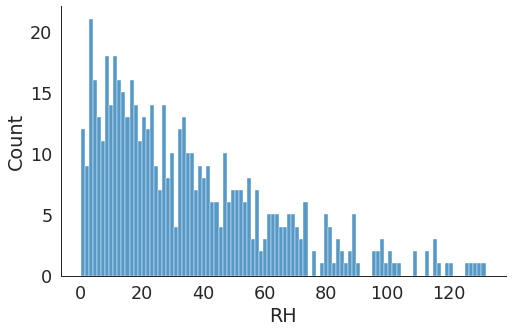

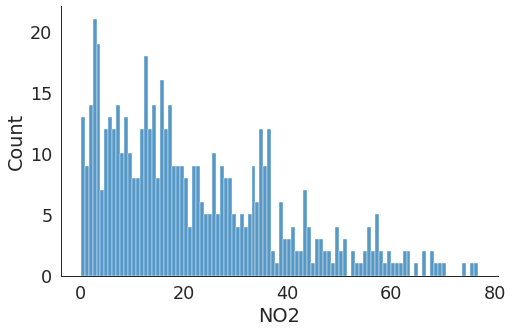

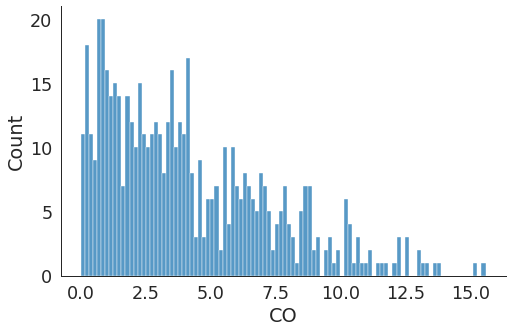

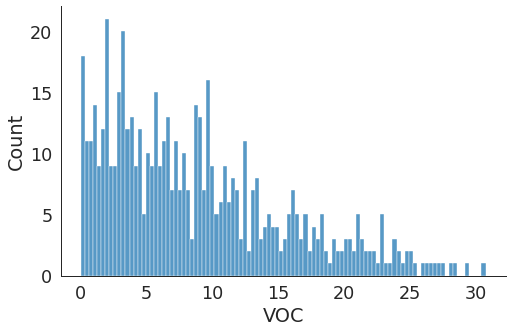

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error          aic          bic  kl_div
beta             0.001350  1054.027279 -7330.143107     inf
burr             0.001685  1066.665547 -7204.081884     inf
gamma            0.001710  1047.583864 -7202.009396     inf
pearson3         0.001711  1047.584540 -7202.007291     inf
expon            0.001887  1043.875323 -7152.566689     inf


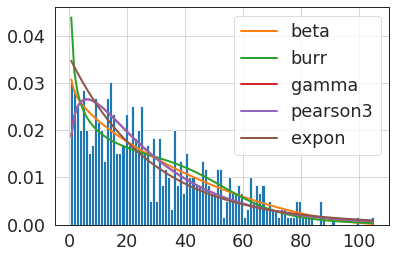

In [ ]:
dis = new_distance["O3"].values
O3_min=min(dis)
O3_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_O=f.fitted_param[distribution]

61.07972415155864 71.90519922259892 88.72147117761295


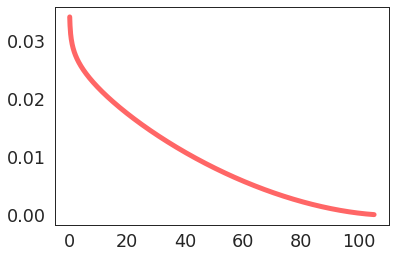

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_O3_l, threshold_O3_m, threshold_O3_h= get_thresholds(dis, param_O, O3_min, O3_max,num_var)
print(threshold_O3_l, threshold_O3_m, threshold_O3_h)


             sumsquare_error         aic          bic  kl_div
beta                0.211570  571.730492 -4459.173933     inf
weibull_min         0.215062  563.941282 -4456.216841     inf
gamma               0.221734  558.524003 -4438.862859     inf
pearson3            0.221744  558.533446 -4438.838072     inf
invgauss            0.254059  563.414828 -4361.566136     inf


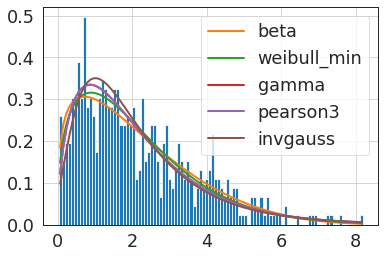

In [ ]:
dis = new_distance["PM2.5"].values
PM2_min=min(dis)
PM2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_P=f.fitted_param[distribution]

4.368819605026456 5.178721796903283 6.634909576237376


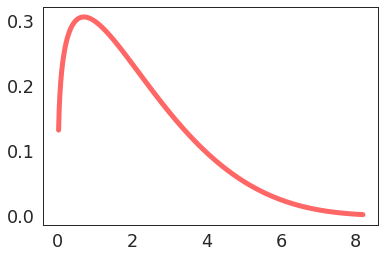

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM2_l, threshold_PM2_m, threshold_PM2_h= get_thresholds(dis, param_P, PM2_min, PM2_max,num_var)
print(threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)


             sumsquare_error         aic          bic  kl_div
beta                0.043289  716.179974 -5360.396254     inf
burr                0.046604  729.774157 -5318.482728     inf
weibull_min         0.048871  721.109187 -5297.851774     inf
gamma               0.050946  720.336304 -5274.228042     inf
pearson3            0.050947  720.337029 -5274.222151     inf


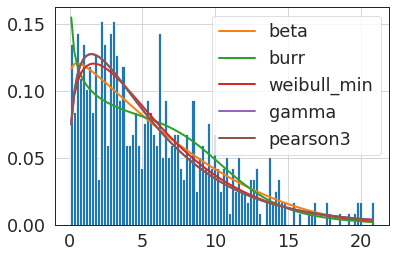

In [ ]:
dis = new_distance["CO2"].values
CO2_min=min(dis)
CO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO2=f.fitted_param[distribution]

12.335881850552504 14.613241405167043 18.4366982720887


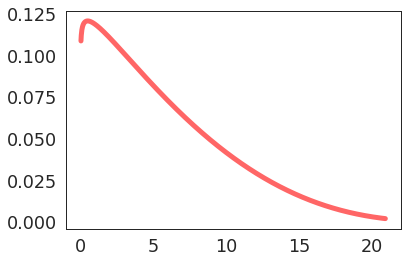

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO2_l, threshold_CO2_m, threshold_CO2_h= get_thresholds(dis, param_CO2, CO2_min, CO2_max,num_var)
print(threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)


             sumsquare_error         aic          bic  kl_div
beta                2.653414  299.230633 -3022.675306     inf
weibull_min         2.791184  307.181780 -3000.266046     inf
burr                2.873896  314.347397 -2977.336683     inf
gamma               2.918390  307.604494 -2974.952444     inf
pearson3            2.918503  307.614946 -2974.930455     inf


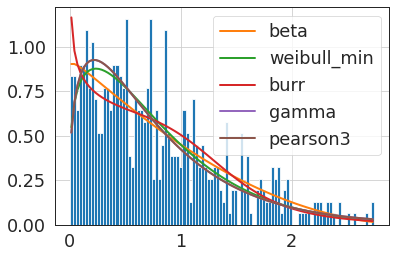

In [ ]:
dis = new_distance["Temp. int."].values
Temp_min=min(dis)
Temp_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_Temp= f.fitted_param[distribution]

1.6772529939174576 1.9735742704894184 2.44274962506169


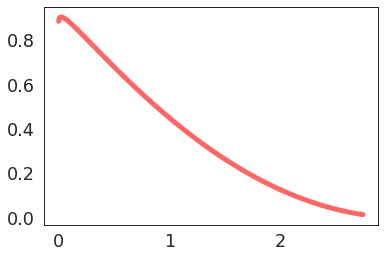

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_Temp_l, threshold_Temp_m, threshold_Temp_h= get_thresholds(dis, param_Temp, Temp_min, Temp_max,num_var)
print(threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

             sumsquare_error         aic          bic  kl_div
beta                2.247717  286.425932 -3116.924749     inf
burr                2.527741  287.207927 -3050.235334     inf
weibull_min         2.640085  294.430140 -3031.877972     inf
pearson3            2.730594  295.124849 -3012.731809     inf
gamma               2.730771  295.132973 -3012.694998     inf


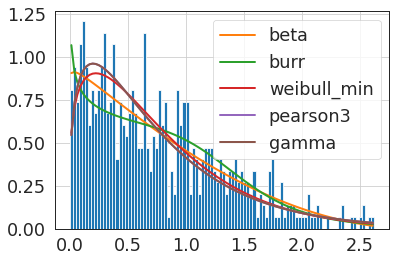

In [ ]:
dis = new_distance["T"].values
T_min=min(dis)
T_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_T=f.fitted_param[distribution]

1.6251833245649856 1.9034817412807687 2.3471839339691405


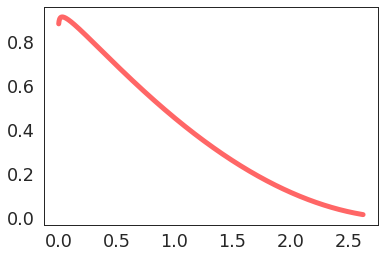

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_T_l, threshold_T_m, threshold_T_h= get_thresholds(dis, param_T, T_min, T_max,num_var)
print(threshold_T_l, threshold_T_m, threshold_T_h)

          sumsquare_error         aic          bic  kl_div
beta             0.041693  733.981919 -5381.737091     inf
burr             0.047518  769.725332 -5307.446010     inf
pearson3         0.051734  724.331092 -5265.512770     inf
gamma            0.051734  724.331731 -5265.507611     inf
invgauss         0.063391  733.407397 -5150.086461     inf


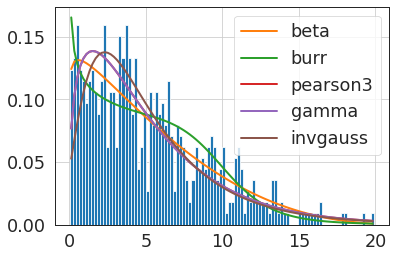

In [ ]:
dis = new_distance["PM10"].values
PM10_min=min(dis)
PM10_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_PM10=f.fitted_param[distribution]

11.068786546829417 13.098822075107302 16.502116931337873


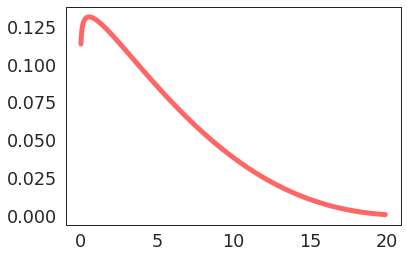

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_PM10_l, threshold_PM10_m, threshold_PM10_h= get_thresholds(dis, param_PM10, PM10_min, PM10_max,num_var)
print(threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)


          sumsquare_error          aic          bic  kl_div
beta             0.000673  1096.247414 -7725.875576     inf
gamma            0.000681  1099.701989 -7724.850961     inf
pearson3         0.000681  1099.701925 -7724.850847     inf
burr             0.000866  1104.585323 -7582.159124     inf
invgauss         0.000930  1108.365562 -7548.064469     inf


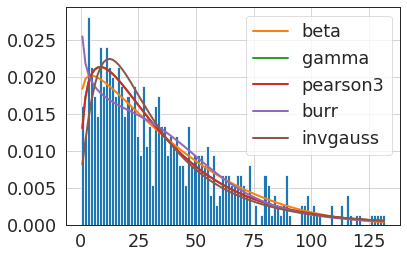

In [ ]:
dis = new_distance["RH"].values
RH_min=min(dis)
RH_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_RH=f.fitted_param[distribution]

74.91370905676156 90.3684658965576 118.10777304490946


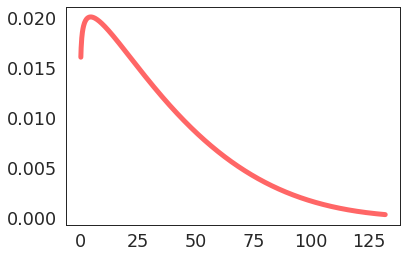

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_RH_l, threshold_RH_m, threshold_RH_h= get_thresholds(dis, param_RH, RH_min, RH_max,num_var)
print(threshold_RH_l, threshold_RH_m, threshold_RH_h)


          sumsquare_error         aic          bic  kl_div
beta             0.003189  967.114288 -6841.823061     inf
gamma            0.003507  974.836695 -6794.170354     inf
pearson3         0.003507  974.837052 -6794.170239     inf
burr             0.003677  980.424872 -6761.029442     inf
triang           0.004115  929.675097 -6703.371556     inf


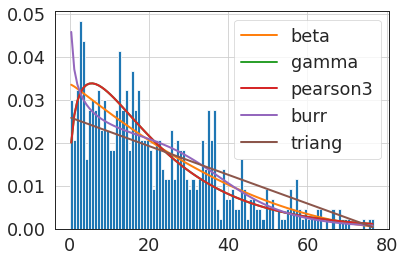

In [ ]:
dis = new_distance["NO2"].values
NO2_min=min(dis)
NO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_NO2=f.fitted_param[distribution]

46.79561628045528 55.0115439482589 68.06488697187213


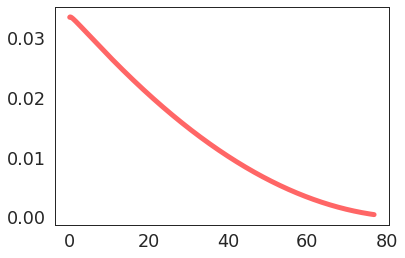

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_NO2_l, threshold_NO2_m, threshold_NO2_h= get_thresholds(dis, param_NO2, NO2_min, NO2_max,num_var)
print(threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

          sumsquare_error         aic          bic  kl_div
beta             0.071140  675.858317 -5078.242478     inf
pearson3         0.079413  671.328886 -5022.098944     inf
gamma            0.079413  671.326065 -5022.095609     inf
burr             0.087857  697.876012 -4958.355764     inf
invgauss         0.102065  679.555641 -4879.557356     inf


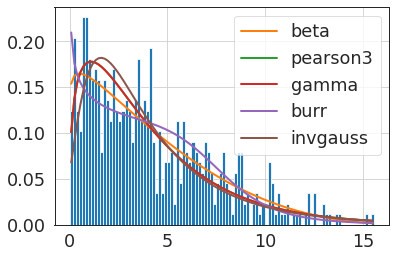

In [ ]:
dis = new_distance["CO"].values
CO_min=min(dis)
CO_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_CO=f.fitted_param[distribution]

8.78232204036708 10.417050854803161 13.15716772471507


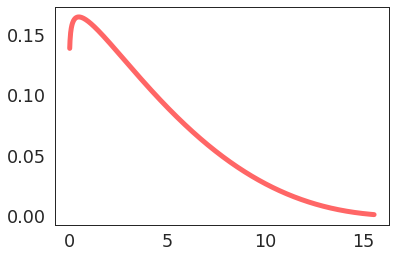

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_CO_l, threshold_CO_m, threshold_CO_h= get_thresholds(dis, param_CO, CO_min, CO_max,num_var)
print(threshold_CO_l, threshold_CO_m, threshold_CO_h)

             sumsquare_error         aic          bic  kl_div
beta                0.020589  790.675026 -5782.486166     inf
burr                0.020859  801.465405 -5775.093106     inf
weibull_min         0.022727  788.631253 -5732.720287     inf
gamma               0.023717  789.159655 -5708.510154     inf
pearson3            0.023717  789.160047 -5708.505173     inf


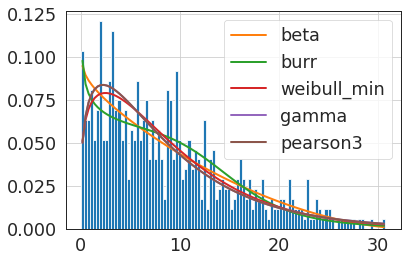

In [ ]:
dis = new_distance["VOC"].values
VOC_min=min(dis)
VOC_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
distribution= f.summary().index[0]
param_VOC=f.fitted_param[distribution]

18.485290040672318 21.67752191073302 26.680731476308924


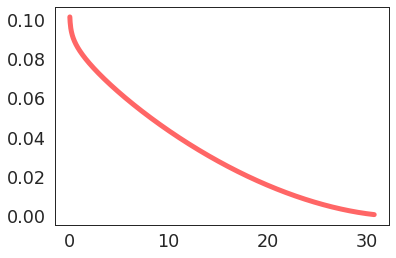

In [ ]:
num_var=get_num_var(distribution)
dis=distributions[distribution]

threshold_VOC_l, threshold_VOC_m, threshold_VOC_h= get_thresholds(dis, param_VOC, VOC_min, VOC_max,num_var)
print(threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)


# Using the thresholds to search anomalies 

In [ ]:
to_show=72
def find_anomalies_thresholds(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i] >= threshold_low) &(errors.iloc[i] < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i] >= threshold_med) &(errors.iloc[i]< threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i] >= threshold_high):
      predictions.iloc[i]=3
  return predictions

data_thresh=df_copy.iloc[-to_show:,:]

Finding anomalies with the burr distribution (O3)

In [ ]:
predictions_O3 = find_anomalies_thresholds(distance['O3'], threshold_O3_l, threshold_O3_m, threshold_O3_h)

data_thresh['Predictions_O3'] = predictions_O3.iloc[-to_show:,:].values
data_thresh['Predictions_O3'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
1.0     2
Name: Predictions_O3, dtype: int64

Finding anomalies with the burr distribution (PM2.5)

In [ ]:
predictions_PM2 = find_anomalies_thresholds(distance['PM2.5'], threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)

data_thresh['Predictions_PM2.5'] = predictions_PM2.iloc[-to_show:,:].values
data_thresh['Predictions_PM2.5'].value_counts()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    61
2.0     5
1.0     4
3.0     2
Name: Predictions_PM2.5, dtype: int64

Finding anomalies with the burr distribution (CO2)

In [ ]:
predictions_CO2 = find_anomalies_thresholds(distance['CO2'], threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)

data_thresh['Predictions_CO2'] = predictions_CO2.iloc[-to_show:,:].values
data_thresh['Predictions_CO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    70
1.0     2
Name: Predictions_CO2, dtype: int64

Finding anomalies with the beta distribution (Temp. int.)

In [ ]:
predictions_Temp = find_anomalies_thresholds(distance['Temp. int.'], threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

data_thresh['Predictions_Temp. int.'] = predictions_Temp.iloc[-to_show:,:].values
data_thresh['Predictions_Temp. int.'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    72
Name: Predictions_Temp. int., dtype: int64

Finding anomalies with the burr distribution (T)


In [ ]:
predictions_T = find_anomalies_thresholds(distance['T'], threshold_T_l, threshold_T_m, threshold_T_h)

data_thresh['Predictions_T'] = predictions_T.iloc[-to_show:,:].values
data_thresh['Predictions_T'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    72
Name: Predictions_T, dtype: int64

Finding anomalies with the burr distribution (PM10)

In [ ]:
predictions_PM10 = find_anomalies_thresholds(distance['PM10'], threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)

data_thresh['Predictions_PM10'] = predictions_PM10.iloc[-to_show:,:].values
data_thresh['Predictions_PM10'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    66
1.0     4
3.0     1
2.0     1
Name: Predictions_PM10, dtype: int64

Finding anomalies with the burr distribution (RH)

In [ ]:
predictions_RH = find_anomalies_thresholds(distance['RH'], threshold_RH_l, threshold_RH_m, threshold_RH_h)

data_thresh['Predictions_RH'] = predictions_RH.iloc[-to_show:,:].values
data_thresh['Predictions_RH'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    72
Name: Predictions_RH, dtype: int64

Finding anomalies with the burr distribution (NO2)

In [ ]:
predictions_NO2 = find_anomalies_thresholds(distance['NO2'], threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

data_thresh['Predictions_NO2'] = predictions_NO2.iloc[-to_show:,:].values
data_thresh['Predictions_NO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    71
1.0     1
Name: Predictions_NO2, dtype: int64

Finding anomalies with the burr distribution (CO)

In [ ]:
predictions_CO = find_anomalies_thresholds(distance['CO'], threshold_CO_l, threshold_CO_m, threshold_CO_h)

data_thresh['Predictions_CO'] = predictions_CO.iloc[-to_show:,:].values
data_thresh['Predictions_CO'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    72
Name: Predictions_CO, dtype: int64

Finding anomalies with the beta distribution (VOC)

In [ ]:
predictions_VOC = find_anomalies_thresholds(distance['VOC'], threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)

data_thresh['Predictions_VOC'] = predictions_VOC.iloc[-to_show:,:].values
data_thresh['Predictions_VOC'].value_counts()
display(data_thresh[-50:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions_O3,Predictions_PM2.5,Predictions_CO2,Predictions_Temp. int.,Predictions_T,Predictions_PM10,Predictions_RH,Predictions_NO2,Predictions_CO,Predictions_VOC
Dates,,,,,,,,,,,,,,,,,,,,
2021-11-27 13,54.616034,2.059072,398.278481,21.382532,9.949367,7.438819,951.379747,25.586498,218.569620,262.502110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-27 19,209.774892,7.017316,414.844156,20.689827,8.674892,9.558442,999.000000,117.112554,229.523810,313.038961,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-28 01,266.233766,13.350649,419.683983,19.932554,8.001299,16.086580,999.000000,118.532468,228.480519,307.173160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-28 07,82.932489,2.050633,414.578059,20.188565,8.659916,9.164557,853.278481,27.603376,211.936709,271.223629,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2021-11-28 13,59.151515,2.012987,410.766234,18.441948,6.688745,5.432900,917.402597,27.731602,209.125541,265.497835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-28 19,223.440678,10.474576,427.021186,14.971144,3.293644,12.745763,986.491525,120.966102,204.995763,315.936441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-29 01,252.257511,9.334764,432.386266,14.074077,2.175107,10.909871,995.948498,136.326180,196.008584,306.296137,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-11-29 07,240.666667,4.877637,440.641350,16.592025,5.153165,6.565401,782.983122,94.535865,187.565401,294.455696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-11-29 13,89.764957,1.388889,427.820513,20.048248,8.508547,2.756410,457.256410,44.440171,158.320513,272.495726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a table with results and differenced data

In [ ]:
data_diff=data_thresh.copy()
for col in df_copy.columns:
  data_diff[col]=df_e[col].iloc[-to_show:]

# Showing the anomalies (differenced values) found with the euclidian distance with graphs

In [ ]:
show_data_diff=data_diff.iloc[-to_show:,:]
day_before= df_e.iloc[-(to_show*2):-to_show,:]
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show, 8)

Using this differencing out[i] = arr[i+1] – arr[i]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_diff.index, 0)
      data_temp = show_data_diff[(data_diff['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal',alpha=0.7, linewidth=1)
      data_expeted= var_fit_df[col].iloc[-to_show:]
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=0.7, linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', alpha=0.7, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red',alpha=0.7, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_diff[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      ax.bar(data_expeted.index, data_expeted ,fill = False, edgecolor = 'black', linewidth=0.5)


      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


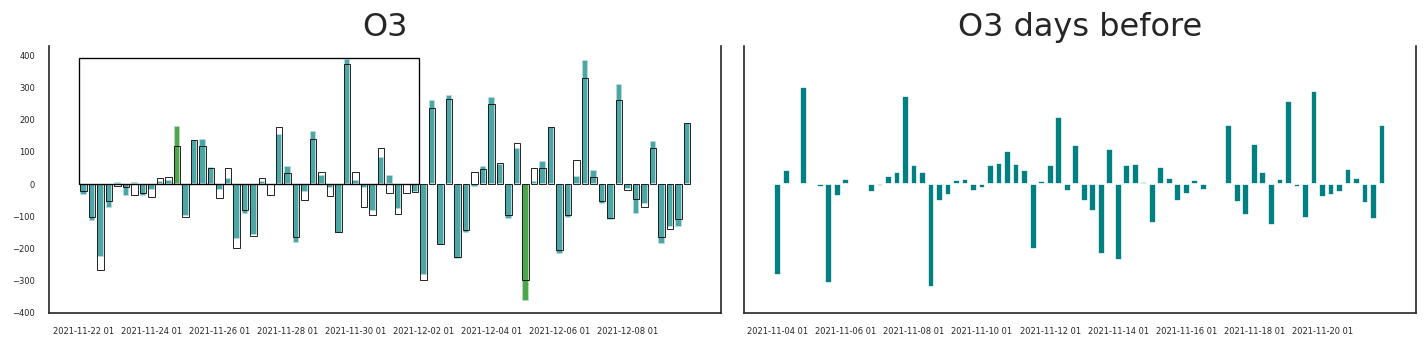

In [ ]:
anomalies_O3_l= show_data_diff[(data_diff['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_diff[(data_diff['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_diff[(data_diff['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

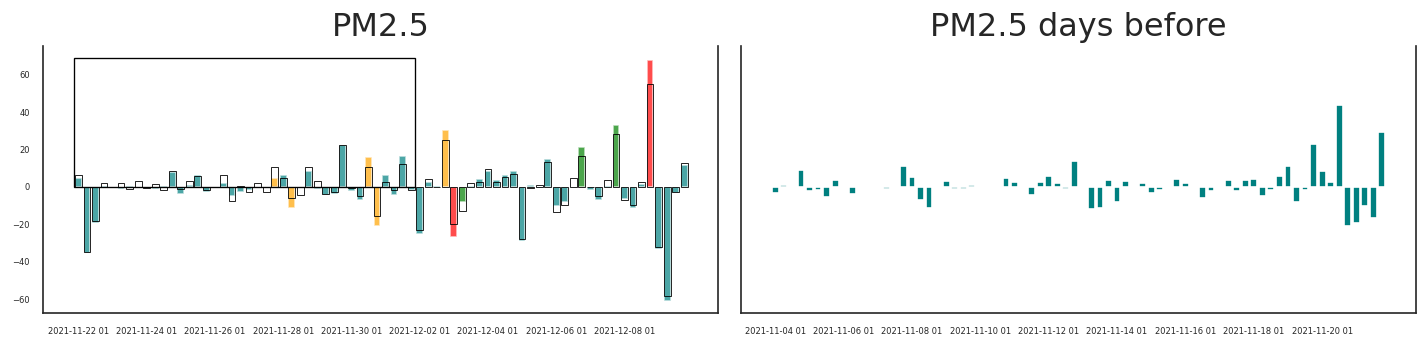

In [ ]:
anomalies_PM2_l= show_data_diff[(data_diff['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_diff[(data_diff['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_diff[(data_diff['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

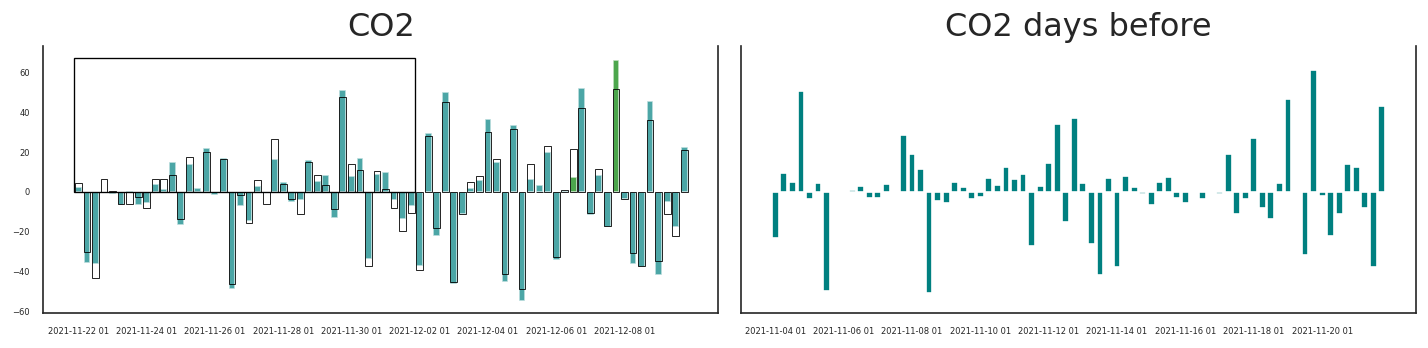

In [ ]:
anomalies_CO2_l= show_data_diff[(data_diff['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_diff[(data_diff['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_diff[(data_diff['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

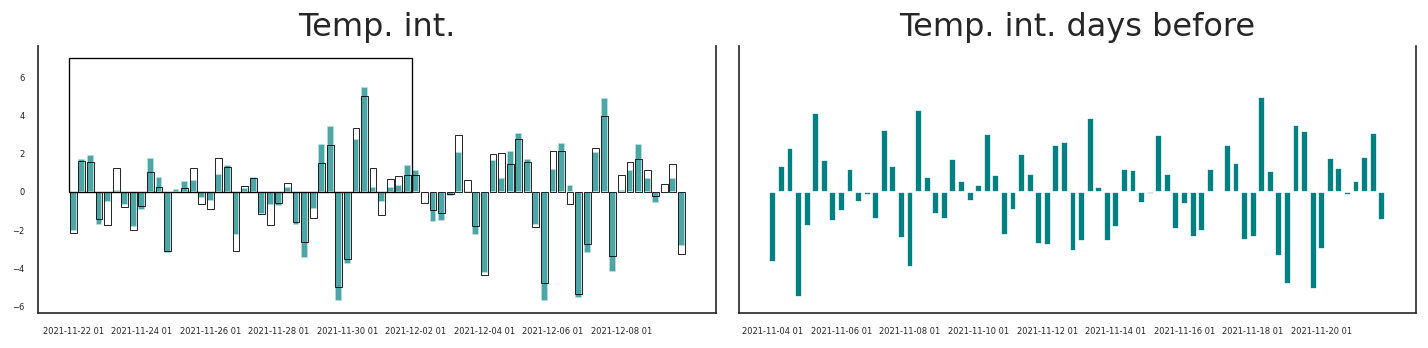

In [ ]:
anomalies_Temp_l= show_data_diff[(data_diff['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_diff[(data_diff['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_diff[(data_diff['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

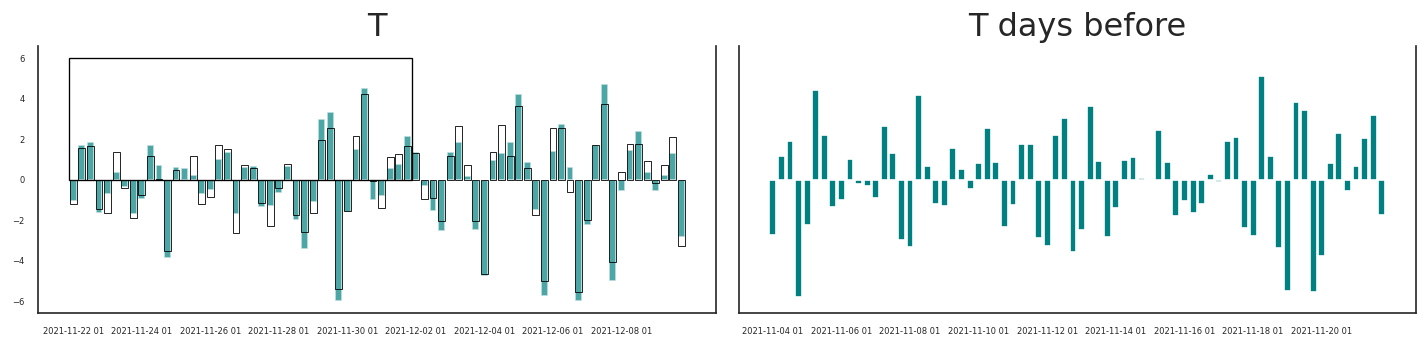

In [ ]:
anomalies_T_l= show_data_diff[(data_diff['Predictions_T'] == 1)]
anomalies_T_m= show_data_diff[(data_diff['Predictions_T'] == 2)]
anomalies_T_h= show_data_diff[(data_diff['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

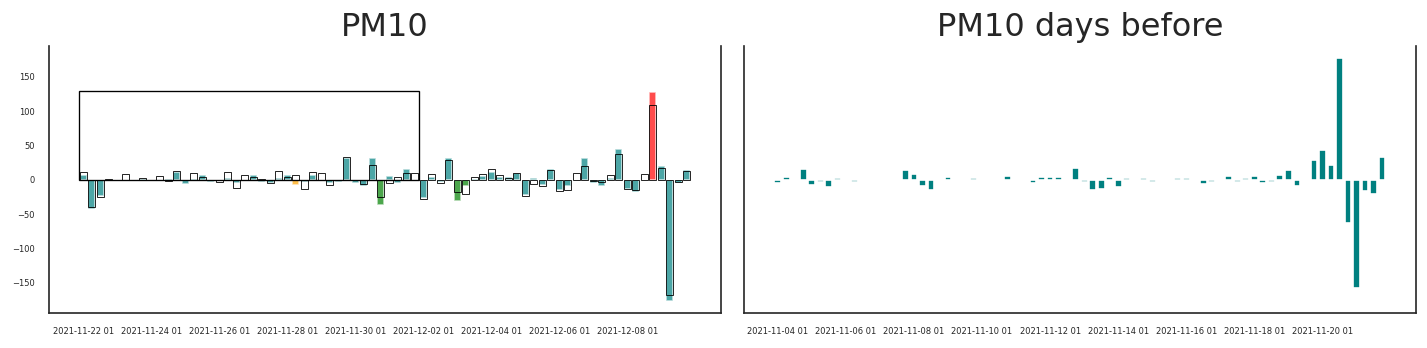

In [ ]:
anomalies_PM10_l= show_data_diff[(data_diff['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_diff[(data_diff['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_diff[(data_diff['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

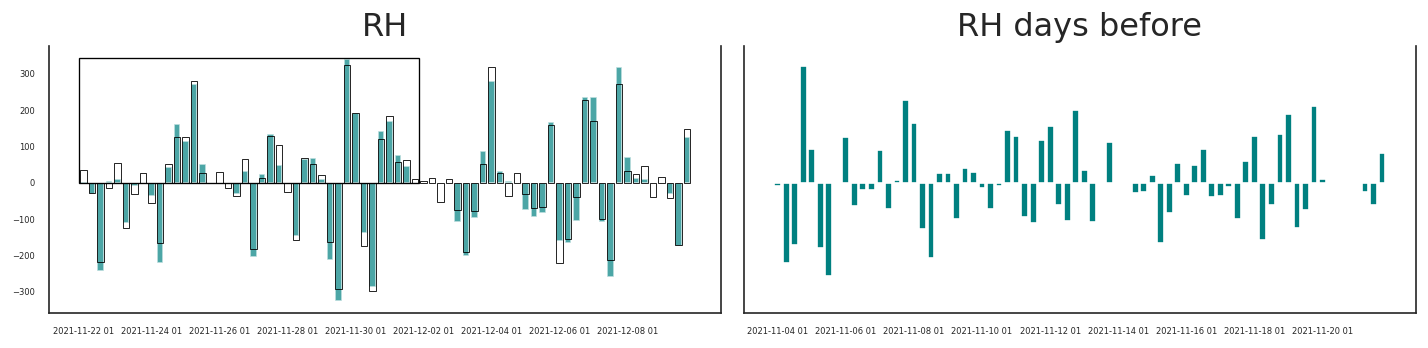

In [ ]:
anomalies_RH_l= show_data_diff[(data_diff['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_diff[(data_diff['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_diff[(data_diff['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

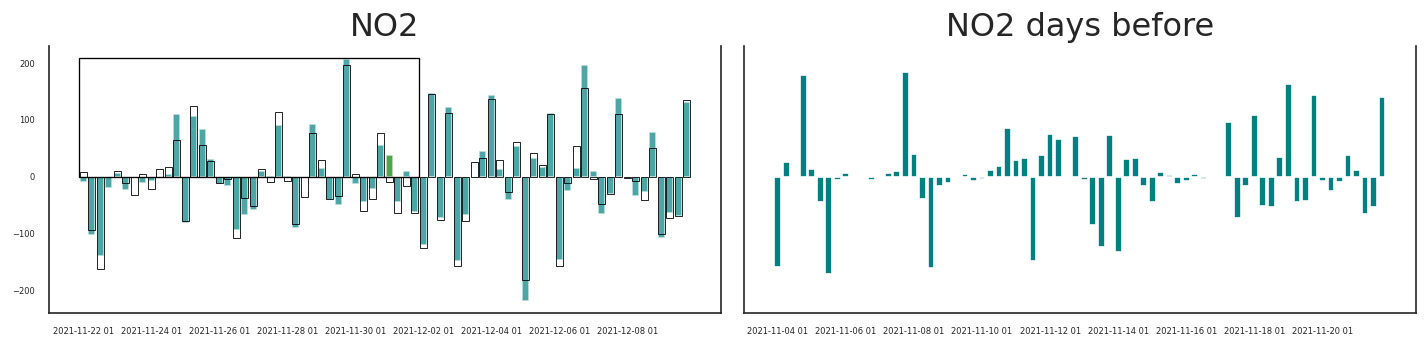

In [ ]:
anomalies_NO2_l= show_data_diff[(data_diff['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_diff[(data_diff['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_diff[(data_diff['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

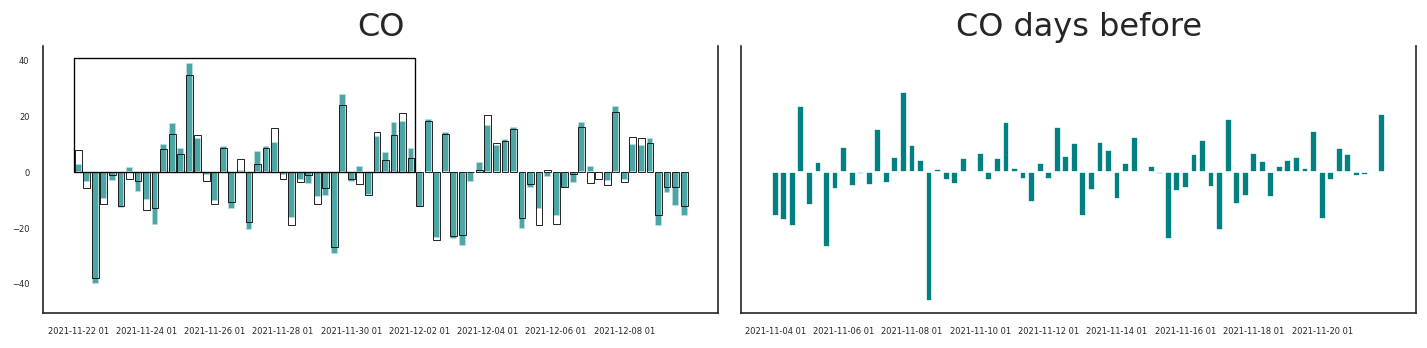

In [ ]:
anomalies_CO_l= show_data_diff[(data_diff['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_diff[(data_diff['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_diff[(data_diff['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

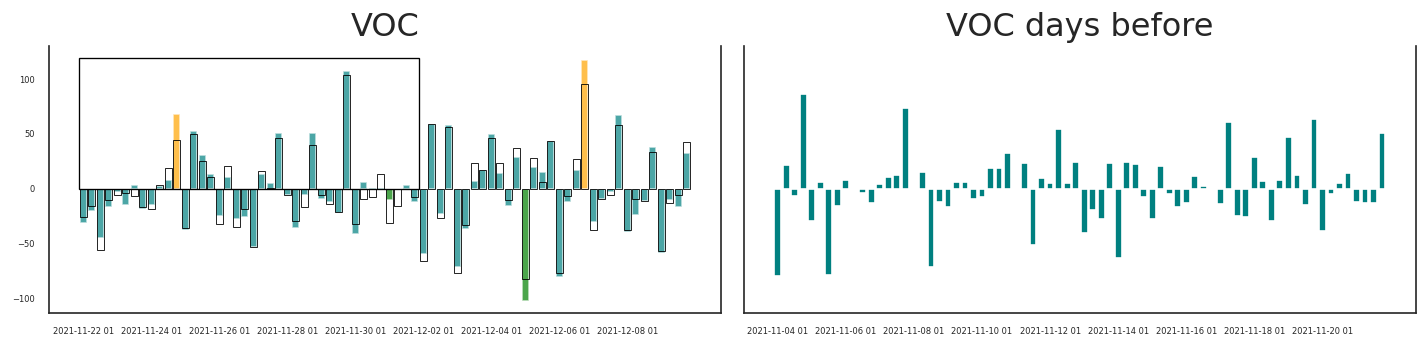

In [ ]:
anomalies_VOC_l= show_data_diff[(data_diff['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_diff[(data_diff['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_diff[(data_diff['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Showing the anomalies found with the euclidian distance with graphs

Reverse differencing the predicted values

In [ ]:
diff_range=6
many_times=to_show/diff_range
difference = pd.DataFrame(index=df_copy.index[-to_show:], columns=df_copy.columns)
for i in range(int(many_times)):
  if(i==many_times-1):
    temp = pd.DataFrame(index=df_copy.index[-diff_range-1:], columns=df_copy.columns)
  else:
    temp = pd.DataFrame(index=df_copy.index[-to_show-1+diff_range*i:-to_show+diff_range*(i+1)], columns=df_copy.columns)
  for col in df_copy.columns:
    if(i==many_times-1):
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-diff_range:][col]
    else:
      x, x_diff = df_copy[col].iloc[-to_show-1+diff_range*i:-to_show+diff_range*i], var_fit_df[-to_show+diff_range*i:-to_show+diff_range*(i+1)][col]
    temp[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  temp=temp.iloc[-diff_range:]
  if(i==many_times-1):
    difference.iloc[-diff_range:]=temp
  else:
    difference.iloc[-to_show+diff_range*i:-to_show+diff_range*(i+1)]=temp

In [ ]:
show_data_thresh=data_thresh.iloc[-to_show:,:]
day_before= df_copy.iloc[-(to_show*2):-to_show,:]
#lines= np.arange(0, to_show, diff_range)
x_ticks = np.arange(0, to_show, 8)
x_ticks_before= np.arange(0, to_show, 8)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

def show_anomalies_euclidian(anomalies_l, anomalies_m, anomalies_h, col):
  # Plot
  fig, axes = plt.subplots(nrows=1, ncols=2, sharey='row', dpi=120, figsize=(12,3))
  plt.setp(axes, xticks=x_ticks)
  for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      ax.bar(show_data_thresh.index, 0)
      data_temp = show_data_thresh[(data_thresh['Predictions_'+col] == 0)][col]
      ax.bar(data_temp.index, data_temp ,color='teal', alpha=1, linewidth=1)
      #ax.bar(difference[col].index, difference[col] ,color='black', alpha=0.5, linewidth=1)
      ax.set_xticks(x_ticks)    
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_l, y_number_list_l, color='green', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_m, y_number_list_m, color='orange', alpha=1, linewidth=1)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[col].values)
      # Draw point based on above x, y axis values.
      ax.bar(x_number_list_h, y_number_list_h, color='red', alpha=1, linewidth=1)
      #lag rectangle
      left, bottom, width, height = (-0.5, 0, 1*selected_lag_eucl, int(max(show_data_thresh[col]+2)))
      ax.add_patch(matplotlib.patches.Rectangle((left,bottom), width, height,fill= None,
                        alpha=1, color="black"))
      #lines
      #for j in range(len(lines)):
       # ax.axvline(lines[j]	, color='black', alpha=0.3)

      # Decorations
      ax.set_title(col)
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)
    else:
      data_before = day_before[col]
      ax.bar(data_before.index, data_before, color='teal', linewidth=1)
      ax.set_xticks(x_ticks_before)
      # Decorations
      ax.set_title(col+' days before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=5)

  plt.tight_layout();


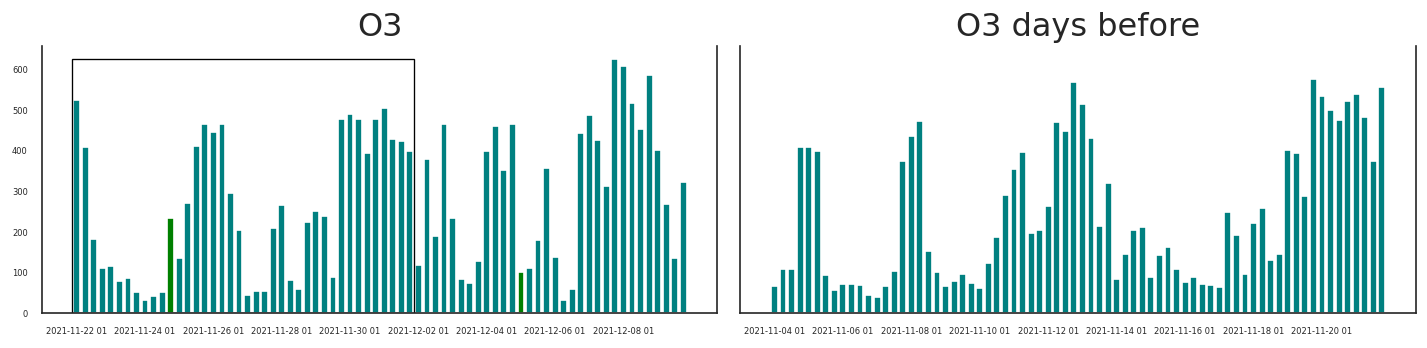

In [ ]:
anomalies_O3_l= show_data_thresh[(data_thresh['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_thresh[(data_thresh['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_thresh[(data_thresh['Predictions_O3'] == 3)]

show_anomalies_euclidian(anomalies_O3_l, anomalies_O3_m, anomalies_O3_h, 'O3')

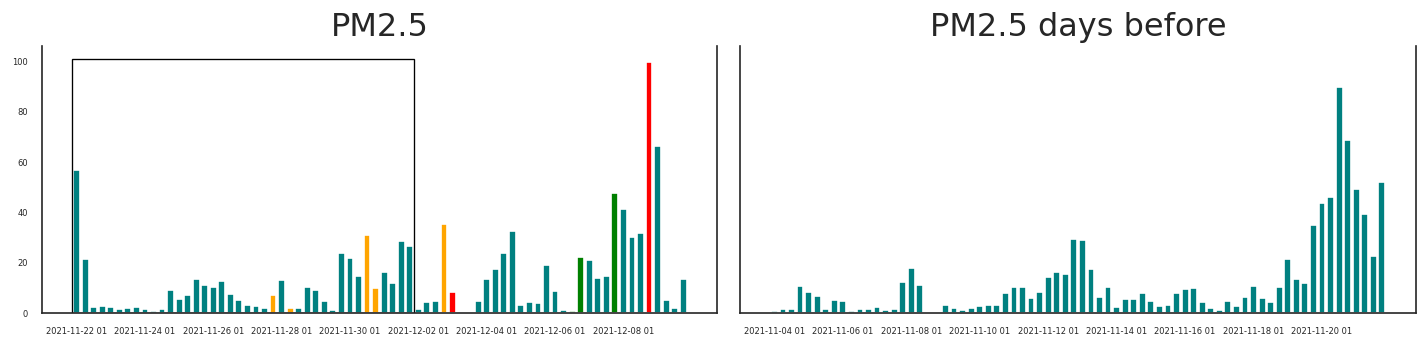

In [ ]:
anomalies_PM2_l= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 3)]

show_anomalies_euclidian(anomalies_PM2_l, anomalies_PM2_m, anomalies_PM2_h, 'PM2.5')

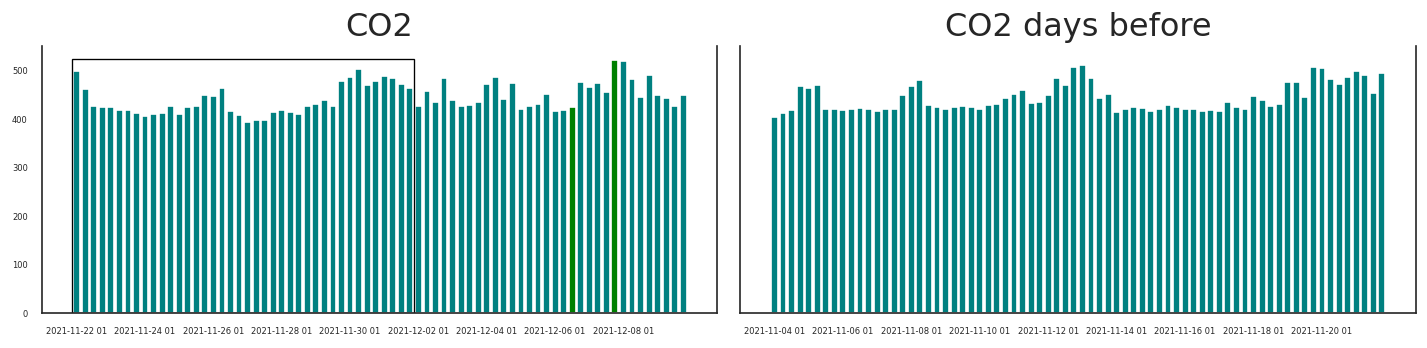

In [ ]:
anomalies_CO2_l= show_data_thresh[(data_thresh['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_thresh[(data_thresh['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_thresh[(data_thresh['Predictions_CO2'] == 3)]

show_anomalies_euclidian(anomalies_CO2_l, anomalies_CO2_m, anomalies_CO2_h, 'CO2')

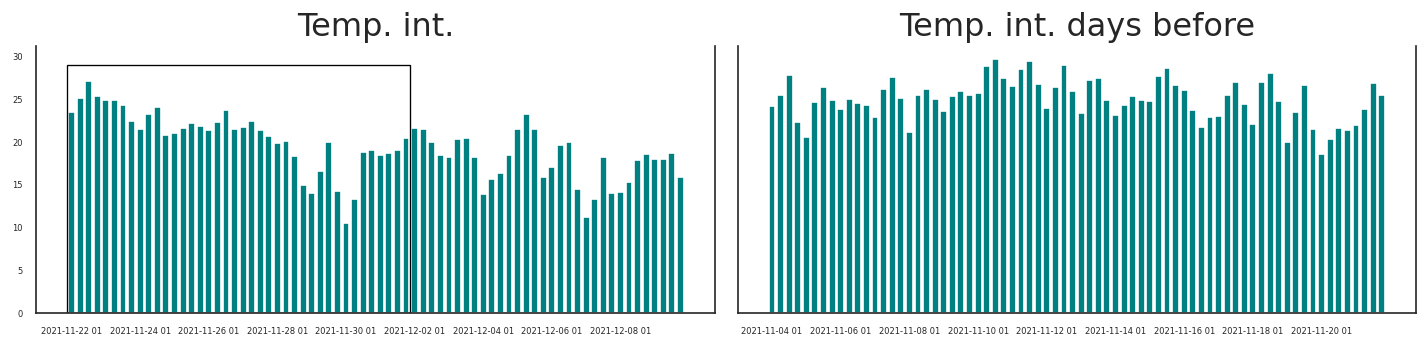

In [ ]:
anomalies_Temp_l= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 1)]
anomalies_Temp_m= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 2)]
anomalies_Temp_h= show_data_thresh[(data_thresh['Predictions_Temp. int.'] == 3)]


show_anomalies_euclidian(anomalies_Temp_l, anomalies_Temp_m, anomalies_Temp_h, 'Temp. int.')

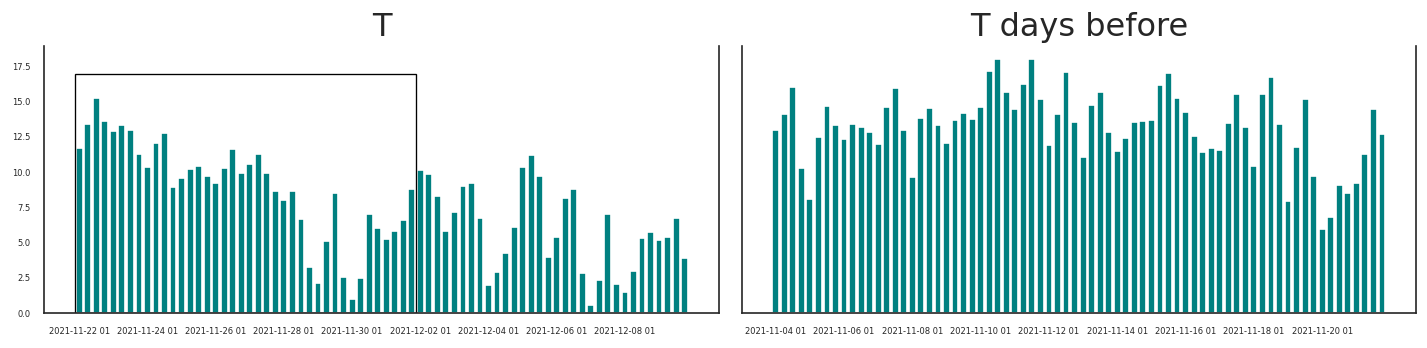

In [ ]:
anomalies_T_l= show_data_thresh[(data_thresh['Predictions_T'] == 1)]
anomalies_T_m= show_data_thresh[(data_thresh['Predictions_T'] == 2)]
anomalies_T_h= show_data_thresh[(data_thresh['Predictions_T'] == 3)]

show_anomalies_euclidian(anomalies_T_l, anomalies_T_m, anomalies_T_h, 'T')

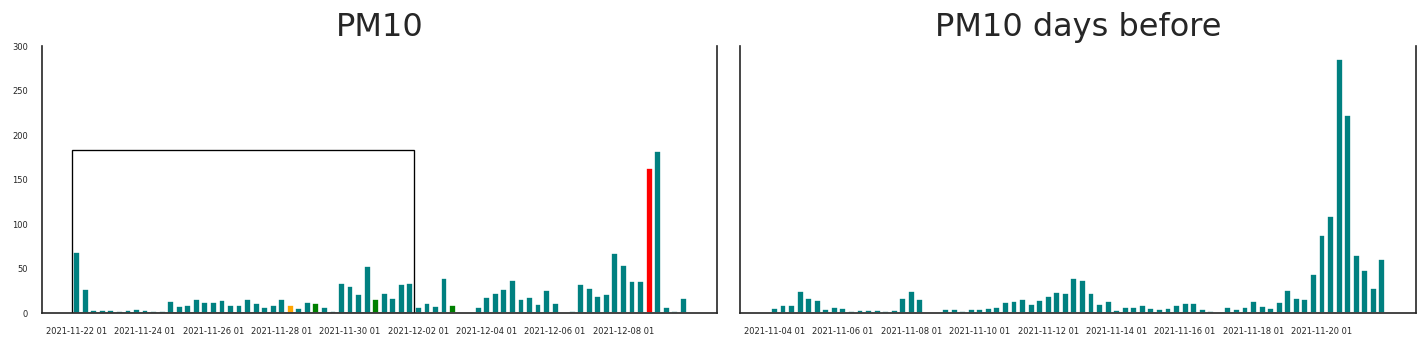

In [ ]:
anomalies_PM10_l= show_data_thresh[(data_thresh['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_thresh[(data_thresh['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_thresh[(data_thresh['Predictions_PM10'] == 3)]

show_anomalies_euclidian(anomalies_PM10_l, anomalies_PM10_m, anomalies_PM10_h, 'PM10')

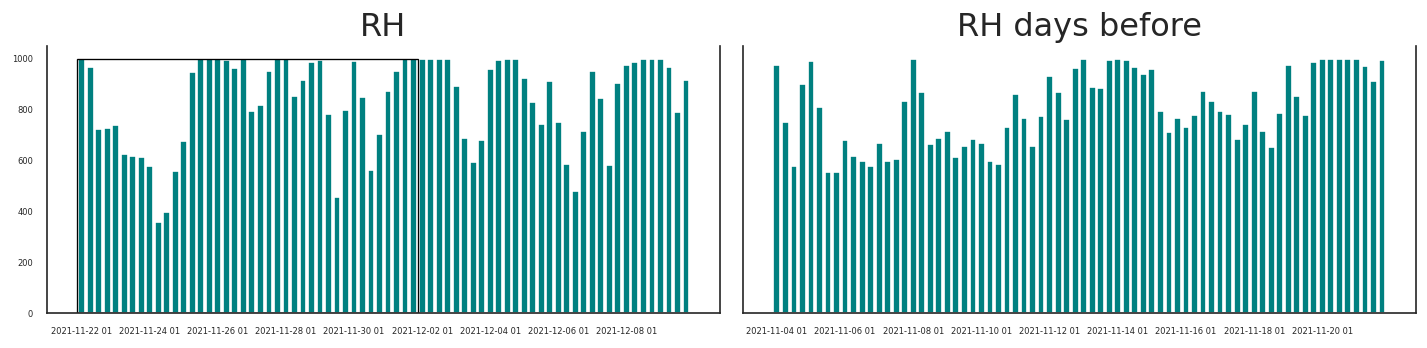

In [ ]:
anomalies_RH_l= show_data_thresh[(data_thresh['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_thresh[(data_thresh['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_thresh[(data_thresh['Predictions_RH'] == 3)]

show_anomalies_euclidian(anomalies_RH_l, anomalies_RH_m, anomalies_RH_h, 'RH')

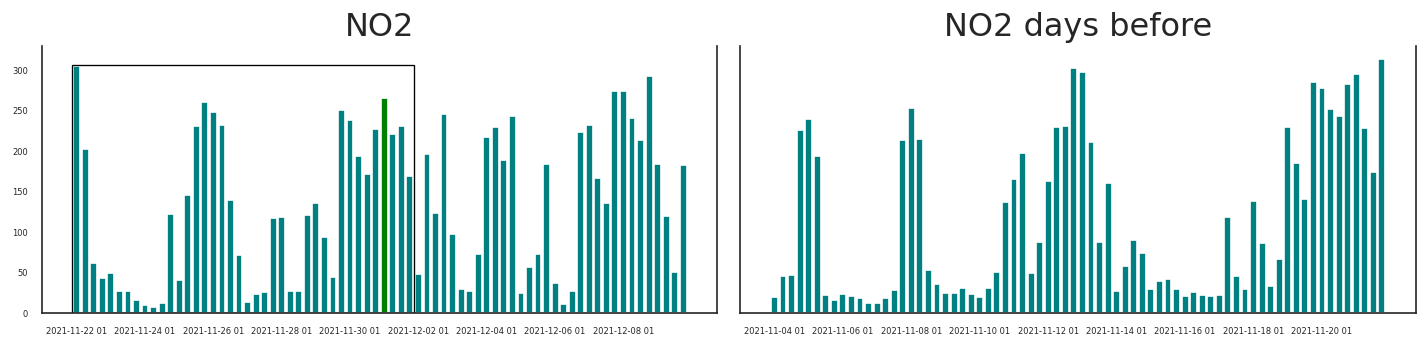

In [ ]:
anomalies_NO2_l= show_data_thresh[(data_thresh['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_thresh[(data_thresh['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_thresh[(data_thresh['Predictions_NO2'] == 3)]

show_anomalies_euclidian(anomalies_NO2_l, anomalies_NO2_m, anomalies_NO2_h, 'NO2')

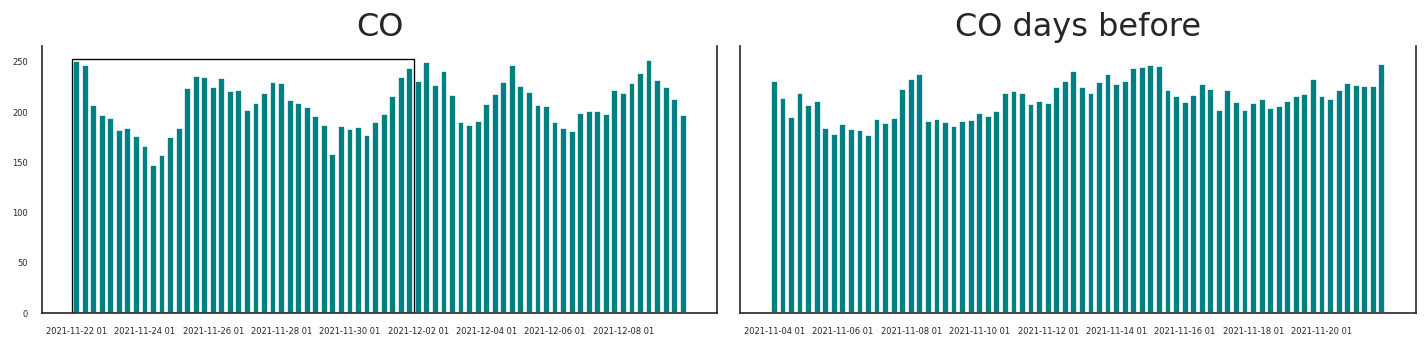

In [ ]:
anomalies_CO_l= show_data_thresh[(data_thresh['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_thresh[(data_thresh['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_thresh[(data_thresh['Predictions_CO'] == 3)]

show_anomalies_euclidian(anomalies_CO_l, anomalies_CO_m, anomalies_CO_h, 'CO')

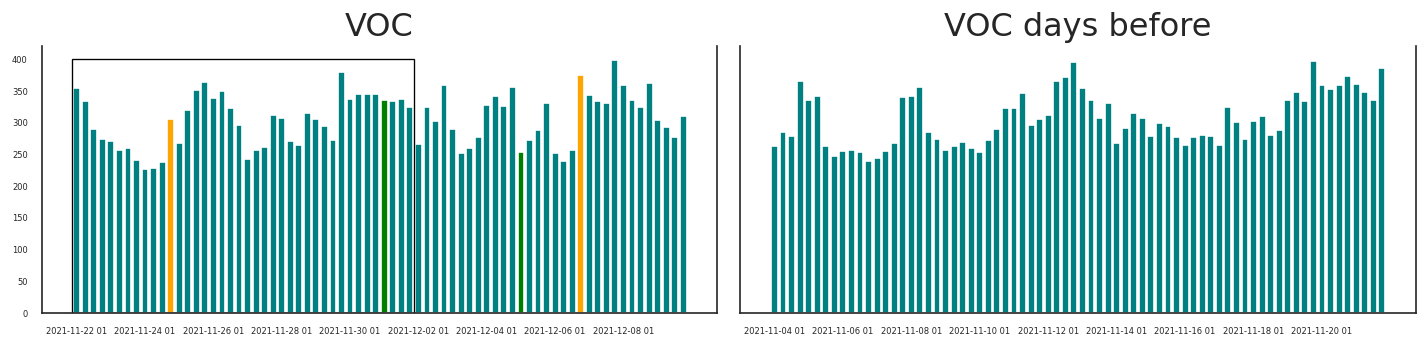

In [ ]:
anomalies_VOC_l= show_data_thresh[(data_thresh['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_thresh[(data_thresh['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_thresh[(data_thresh['Predictions_VOC'] == 3)]

show_anomalies_euclidian(anomalies_VOC_l, anomalies_VOC_m, anomalies_VOC_h, 'VOC')

# Forecast all

Splitting the series into train and testing data (to_predict= how many values are going to be predicted, forecast_interval= how often the forecast will happen)

to_predict must be a multiple of forecast_interval

In [ ]:
to_predict=48
forecast_interval = 3
df_train, df_test = df_copy[0:-to_predict].copy(), df_copy[-to_predict:].copy()
df_train_inputs=df_copy.copy()

# Check size
print(df_train.shape)  
print(df_test.shape)  

(601, 10)
(48, 10)


Check stationarity with all values and only with the starting values

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results_end = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
display(adf_test_results_end)


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in ['T', 'Temp. int.']:
    df_train[col] = differencing(df_train, col, 1)
#anche gli input devono essere post differencing se train viene differenziato e usato nel modello
for col in ['T', 'Temp. int.']:
    df_train_inputs[col] = differencing(df_train_inputs, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR

max_lag=25
model_lag = VAR(df_train.astype(float))
lag_results_for = model_lag.select_order(max_lag)
selected_lag_for = lag_results_for.aic
print(selected_lag_for)
df_inputs=df_train_inputs[-to_predict-selected_lag_for:-forecast_interval].copy()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5


In [ ]:
res_fc=pd.DataFrame(index=df_copy.index[-to_predict:], columns=df_copy.columns)
how_many_times=to_predict/forecast_interval
allvalues=[]
model=VAR(df_train.astype(float))
model_fitted = model.fit(selected_lag_for)
var_summaryfor=str(model_fitted.summary())
print(var_summaryfor[0:624])
for i in range(int(how_many_times)):
  if(i==how_many_times-1):
    forecast_input = df_inputs.iloc[-selected_lag_for:].values
  else:
    forecast_input = df_inputs.iloc[(i)*forecast_interval:(i)*forecast_interval+selected_lag_for].values
  fc = model_fitted.forecast(y=forecast_input, steps=forecast_interval)
  if(i==how_many_times-1):
    temp = pd.DataFrame(fc, index=df_copy.index[-forecast_interval:], columns=df_copy.columns)
    diff= pd.DataFrame( index=df_copy.index[-forecast_interval-1:], columns=['T','Temp. int.'])
  else:
    temp = pd.DataFrame(fc, index=df_copy.index[-to_predict+i*forecast_interval:-to_predict+(i+1)*forecast_interval], columns=df_copy.columns)
    diff = pd.DataFrame(index=df_copy.index[-to_predict+i*forecast_interval-1:-to_predict+(i+1)*forecast_interval], columns=['T','Temp. int.'])
  for col in ['T', 'Temp. int.', 'NO2']:
    x, x_diff = df_copy[col].iloc[-to_predict+i*forecast_interval-1:-to_predict+i*forecast_interval], temp[col]
    diff[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  diff=diff.iloc[-forecast_interval:]
  for col in ['T', 'Temp. int.', 'NO2']:
    temp[col]=diff[col]
  res_fc.iloc[i*forecast_interval:(i+1)*forecast_interval]=temp
display(res_fc)
  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jan, 2022
Time:                     08:14:31
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    43.6038
Nobs:                     596.000    HQIC:                   41.3099
Log likelihood:          -19821.3    FPE:                2.02841e+17
AIC:                      39.8470    Det(Omega_mle):     8.92431e+16
--------------------------------------------------------------------



,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-11-28 01,190.796,7.91746,417.011,21.0559,9.23952,17.8435,954.194,233.891,225.083,289.519
2021-11-28 07,187.584,8.81182,428.458,21.0453,9.32252,18.0615,951.995,368.126,222.187,297.222
2021-11-28 13,181.769,8.46029,426.68,21.2095,9.5172,14.2885,931.198,492.701,215.921,293.511
2021-11-28 19,176.398,9.42903,427.181,18.1766,6.23351,17.8488,945.627,134.562,211.175,298.467
2021-11-29 01,181.669,7.18542,427.185,20.2477,8.15734,12.3941,857.023,225.151,205.527,291.011
2021-11-29 07,116.846,5.85441,425.335,19.1331,7.40491,10.1021,837.888,297.554,203.179,275.928
2021-11-29 13,91.8891,4.24168,425.899,17.3534,5.96279,8.73082,674.831,129.59,176.561,261.536
2021-11-29 19,129.346,7.34592,432.94,14.4858,3.11266,11.1934,789.493,210.606,180.684,284.381
2021-11-30 01,171.21,9.87831,434.221,15.5994,3.96692,17.6279,779.404,298.648,178.837,281.65


In [ ]:
fc_index=res_fc.index
for_index=[]
for i in range(len(fc_index)):
  if(i%forecast_interval==0):
    for_index.append(fc_index[i])

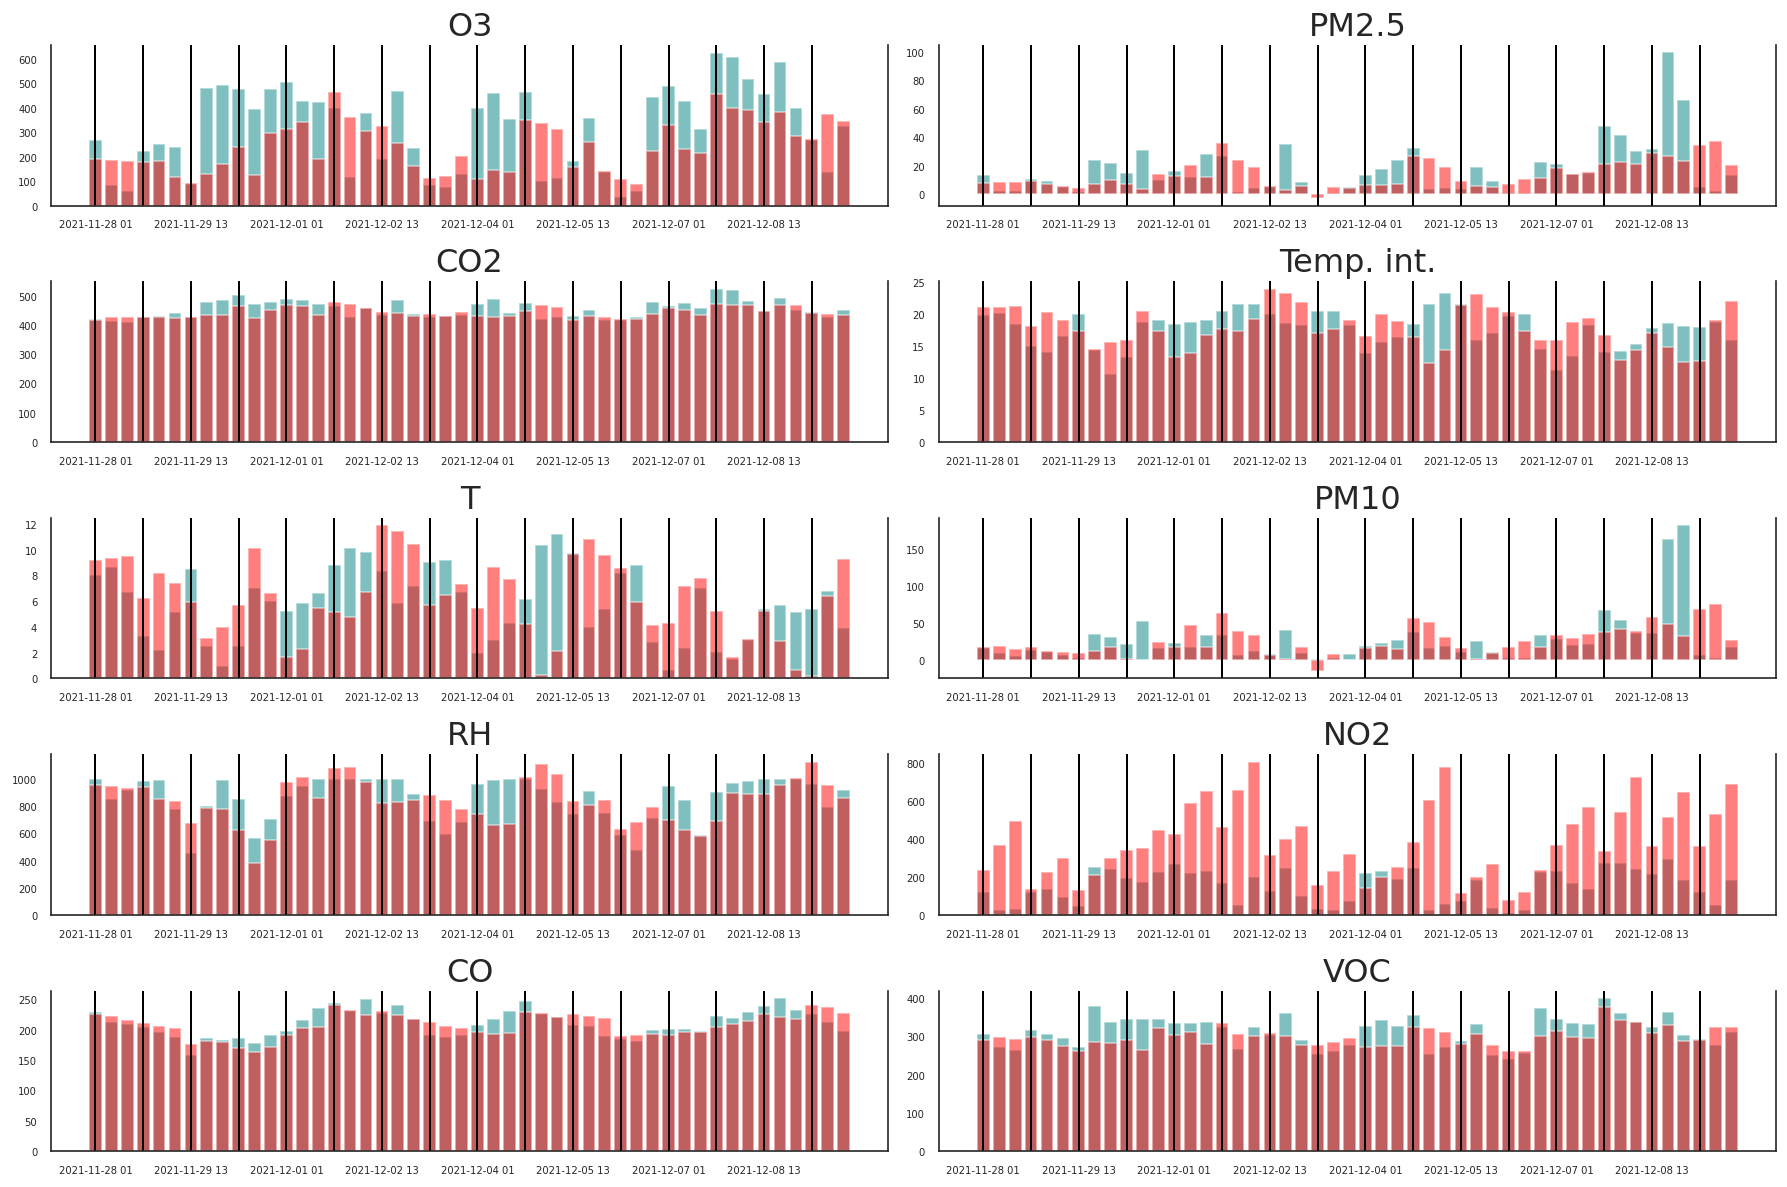

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if(len(df_train.columns)==10):
  num_row=5
else:
  num_row=6
x_ticks = np.arange(0, to_predict, 6)
# Plot
fig, axes = plt.subplots(nrows=num_row, ncols=2, dpi=120, figsize=(15,10))
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
  if(i<len(df_train.columns)):
    data_for = df_test[df_test.columns[i]]
    data_res_fc=res_fc[res_fc.columns[i]]
    ax.bar(data_for.index, data_for, alpha=0.5,color='teal', linewidth=1)
    ax.bar(data_res_fc.index, data_res_fc, alpha=0.5,color='red', linewidth=1)
    for j in range(len(for_index)):
      ax.axvline(for_index[j]	, color='black')
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.set_xticks(x_ticks)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    if(all (np.abs(actual))!=0):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
      mpe = np.mean((forecast - actual)/actual)   # MPE
    else: 
    #10 significa che non è calcolabile perchè actual è nullo
      mape=10
      mpe=10
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    if(all (maxs)!=0):
      minmax = 1 - np.mean(mins/maxs)             # minmax
    else: 
      minmax=10
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  'minmax':minmax})
for col in df_copy.columns:
  print('Forecast Accuracy of: '+col)
  accuracy_prod = forecast_accuracy(res_fc[col].values, df_test[col])
  for k, v in accuracy_prod.items():
     print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: O3
mape   :  0.6002
me     :  -75.0756
mae    :  142.816
mpe    :  0.0852
rmse   :  169.649
minmax :  0.3944
Forecast Accuracy of: PM2.5
mape   :  2.5685
me     :  -3.3772
mae    :  12.2561
mpe    :  1.0697
rmse   :  18.1397
minmax :  1.0041
Forecast Accuracy of: CO2
mape   :  0.046
me     :  -11.7244
mae    :  21.4992
mpe    :  -0.0232
rmse   :  27.4677
minmax :  0.0453
Forecast Accuracy of: Temp. int.
mape   :  0.191
me     :  0.1718
mae    :  3.2537
mpe    :  0.035
rmse   :  3.8885
minmax :  0.1657
Forecast Accuracy of: T
mape   :  0.8117
me     :  0.3365
mae    :  3.1009
mpe    :  0.4556
rmse   :  3.8153
minmax :  0.4102
Forecast Accuracy of: PM10
mape   :  3.2144
me     :  -1.8293
mae    :  21.8586
mpe    :  0.2737
rmse   :  35.5499
minmax :  1.7615
Forecast Accuracy of: RH
mape   :  0.158
me     :  -22.3158
mae    :  128.0777
mpe    :  -0.0076
rmse   :  153.2127
minmax :  0.1429
Forecast Accuracy of: NO2
mape   :  3.3462
me     :  233.9054
mae    :  240.2554

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


# Diving the wind in 3 different categories and using them to create 3 different forecasts

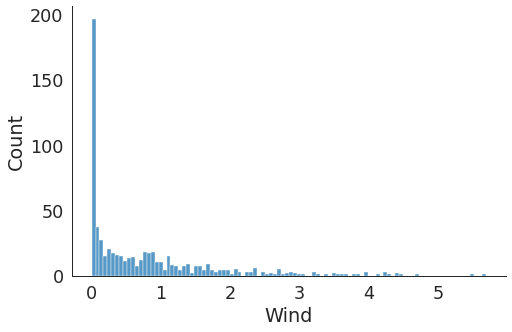

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats

df_c=df_copy.copy()
df_train_inputs_w=df_copy.copy()

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_c, x='Wind', kind="hist", bins = 100, aspect = 1.5)

The wind values are diveded in categories: no wind, weak and strong wind.
Weak wind values are between 0 and threshold_wind, strong wind values are greater than threshold_wind

In [ ]:
threshold_wind=1

Count how many values would go in each category to find a good threshold

In [ ]:
cnt_w=0
cnt_s=0
cnt_n=0
for i in range(len(df_c)):
  if df_c['Wind'].iloc[i]==0:
    cnt_n+=1
  elif df_c['Wind'].iloc[i]<threshold_wind:
    cnt_w+=1
  else:
    cnt_s+=1
print(cnt_n)
print(cnt_w)
print(cnt_s)

109
355
180


Create 3 tables (1 for each type of wind)

In [ ]:
df_c_n=df_c[(df_c['Wind'] ==0)]
df_c_temp=df_c[(df_c['Wind'] > 0 )]
df_c_w=df_c_temp[(df_c_temp['Wind'] < threshold_wind)]
df_c_s=df_c[(df_c['Wind'] >= threshold_wind)]
display(df_c_n)
display(df_c_w)
display(df_c_s)

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-07-12 20,446.099138,1.745690,410.198276,41.288319,27.976724,7.512931,473.625000,278.853448,235.271552,385.211207,0
2021-07-17 02,307.354978,0.956710,421.480519,33.675281,20.383983,2.549784,722.896104,233.805195,225.458874,314.311688,0
2021-07-23 02,441.238318,10.238318,427.892523,36.918551,23.491121,13.032710,900.780374,318.967290,260.560748,358.028037,0
2021-07-24 02,399.754808,5.831731,425.966346,35.947356,22.988462,8.100962,874.831731,280.504808,250.216346,347.346154,0
2021-08-13 02,457.181818,4.255411,450.632035,36.894113,24.810390,8.588745,595.952381,334.575758,253.484848,363.935065,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-02 19,175.378723,4.038298,423.314894,27.293915,15.050638,16.710638,820.931915,66.736170,220.604255,303.051064,0
2021-11-03 01,128.502203,2.330396,420.462555,25.623260,13.507489,11.691630,851.392070,50.035242,209.757709,276.061674,0
2021-11-03 07,320.645161,3.046083,450.663594,25.689770,12.915668,12.387097,959.912442,217.096774,221.944700,336.571429,0
2021-11-03 13,347.101695,4.182203,429.978814,30.177373,17.380085,13.440678,839.343220,193.338983,230.677966,347.322034,0


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-30 02,391.943723,1.943723,410.969697,38.649913,23.567965,8.251082,636.030303,259.796537,228.363636,349.277056,0.808333
2021-06-30 20,342.102439,1.931707,406.882927,39.451024,24.807317,9.878049,481.185366,194.770732,214.868293,343.956098,0.908333
2021-07-01 02,360.782051,2.901709,418.452991,36.407735,21.468803,12.346154,659.307692,280.841880,224.739316,344.807692,0.6875
2021-07-01 20,365.037975,1.324895,410.527426,37.857342,24.384388,7.957806,506.940928,190.582278,213.202532,332.037975,0.3625
2021-07-02 02,314.854077,1.660944,423.364807,32.832189,19.460944,7.291845,711.811159,224.987124,221.459227,320.987124,0.466667
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 01,608.815451,41.313305,519.690987,14.212618,1.494421,54.248927,974.982833,274.094421,219.253219,360.231760,0.670833
2021-12-08 07,516.871795,30.222222,483.696581,15.385940,2.964103,35.829060,987.884615,240.897436,229.273504,336.299145,0.95
2021-12-08 19,587.514894,99.782979,491.906383,18.630894,5.730213,163.514894,999.000000,292.680851,251.502128,362.740426,0.745833
2021-12-09 01,400.914163,66.433476,450.150215,18.057897,5.192704,182.957082,999.000000,184.836910,232.240343,303.982833,0.833333


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-06-29 08,457.703704,1.296296,410.481481,43.327778,29.644444,6.037037,404.148148,244.000000,216.629630,375.481481,1.17917
2021-06-29 14,523.896175,1.218579,408.027322,46.536011,32.412022,6.737705,384.519126,253.109290,226.464481,404.349727,2.825
2021-06-29 20,452.995327,1.238318,407.990654,42.546636,28.035047,6.032710,490.635514,249.331776,226.074766,376.369159,1.00417
2021-06-30 08,414.850877,1.890351,406.438596,41.504825,26.664474,10.688596,487.500000,278.307018,219.114035,364.780702,3.375
2021-06-30 14,367.920188,1.478873,404.793427,42.425915,28.065258,9.164319,339.309859,194.403756,198.380282,360.323944,3.26667
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06 13,59.116379,1.034483,425.797414,20.052716,8.826724,2.021552,479.193966,27.224138,180.745690,257.176724,1.79167
2021-12-07 19,625.189076,47.890756,523.033613,14.090588,2.059664,67.142857,904.415966,274.306723,221.953782,399.487395,1.03333
2021-12-08 13,454.186441,31.923729,446.322034,17.882797,5.360169,36.258475,999.000000,213.576271,239.161017,325.012712,1.17083
2021-12-09 07,268.345992,5.371308,444.890295,18.001477,5.412658,6.637131,966.894515,120.046414,224.987342,293.683544,1.47083


Create 3 different forecast models and use them

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results_n= {
    col: test_stationarity(df_c_n, col)
    for col in df_c_n.columns
}
display(adf_test_results_n)    

adf_test_results_w = {
    col: test_stationarity(df_c_w, col)
    for col in df_c_w.columns
}
display(adf_test_results_w)

adf_test_results_s = {
    col: test_stationarity(df_c_s, col)
    for col in df_c_s.columns
}
display(adf_test_results_s)  

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in double_scalars
  return self.params / self.bse
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Non-Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary',
 'Wind': 'Non-Stationary'}

{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary',
 'Wind': 'Stationary'}

{'CO': 'Stationary',
 'CO2': 'Non-Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Non-Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Non-Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Non-Stationary',
 'Wind': 'Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
#no wind
for col in df_c.columns:
    df_c_n[col] = differencing(df_c_n, col, 1)
#weak wind
for col in df_c.columns:
    df_c_w[col] = differencing(df_c_w, col, 1)
#strong wind
for col in df_c.columns:
    df_c_s[col] = differencing(df_c_s, col, 1)
#inputs
for col in df_c.columns:
    df_train_inputs_w[col] = differencing(df_train_inputs_w, col, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Find the best lag and create the models

In [ ]:
df_c_n=df_c_n.drop('Wind', axis=1)

In [ ]:
from statsmodels.tsa.api import VAR

max_lag=5

model_n = VAR(df_c_n.astype(float))
lag_results_n = model_n.select_order(max_lag)
selected_lag_n = lag_results_n.aic
print('selected lag for the null: '+str(selected_lag_n))
model_fitted_n = model_n.fit(selected_lag_n)
var_summaryn=str(model_fitted_n.summary())
print(var_summaryn[0:624])

model_w = VAR(df_c_w.astype(float))
lag_results_w = model_w.select_order(max_lag)
selected_lag_w = lag_results_w.aic
print('selected lag for the weak: '+str(selected_lag_w))
model_fitted_w = model_w.fit(selected_lag_w)
var_summaryw=str(model_fitted_w.summary())
print(var_summaryw[0:624])

model_s = VAR(df_c_s.astype(float))
lag_results_s = model_s.select_order(max_lag)
selected_lag_s = lag_results_s.aic
print('selected lag for the strong: '+str(selected_lag_s))
model_fitted_s = model_s.fit(selected_lag_s)
var_summarys=str(model_fitted_s.summary())
print(var_summarys[0:624])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


selected lag for the null: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     10:31:16
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    56.2391
Nobs:                     104.000    HQIC:                   48.5250
Log likelihood:          -3215.81    FPE:                1.56193e+19
AIC:                      43.2714    Det(Omega_mle):     2.88853e+17
--------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


selected lag for the weak: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     10:31:17
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    47.3550
Nobs:                     352.000    HQIC:                   44.8835
Log likelihood:          -12732.1    FPE:                6.11061e+18
AIC:                      43.2499    Det(Omega_mle):     2.21612e+18
--------------------------------------------------------------------

selected lag for the strong: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Jan, 2022
Time:                     10:31:17
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    48.2534
Nobs:                     178.000    

Predicting "to_predict_w" values using "forecast_interval_w" in "times" steps.
Finding the median of every "step" to choose the correct model and forecast all values
to_predict_w should always be a multiple of forecast_interval_w

In [ ]:
to_predict_w=48
forecast_interval_w = 3
times= int(to_predict_w/forecast_interval_w)
res_fc=pd.DataFrame(index=df_copy.index[-to_predict_w:], columns=df_copy.columns)
allvalues=[]
df_inputs_no=df_train_inputs_w[-to_predict_w-selected_lag_n:-forecast_interval_w].copy()
df_inputs_weak=df_train_inputs_w[-to_predict_w-selected_lag_w:-forecast_interval_w].copy()
df_inputs_strong=df_train_inputs_w[-to_predict_w-selected_lag_s:-forecast_interval_w].copy()
for i in range(times):
  if(-to_predict_w+(i+1)*forecast_interval_w==0):
    temp=df_c.iloc[-forecast_interval_w:]
    forecast_input_no= df_inputs_no.iloc[-selected_lag_n:].values
    forecast_input_weak= df_inputs_weak.iloc[-selected_lag_w:].values
    forecast_input_strong= df_inputs_strong.iloc[-selected_lag_s:].values
  else:
    temp=df_c.iloc[-to_predict_w+i*forecast_interval_w:-to_predict_w+(i+1)*forecast_interval_w]
    forecast_input_no= df_inputs_no.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_n].values
    forecast_input_weak= df_inputs_weak.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_w].values
    forecast_input_strong= df_inputs_strong.iloc[(i)*forecast_interval_w:(i)*forecast_interval_w+selected_lag_s].values
  if temp['Wind'].median() <= 0.15:
    print(str(i)+' no wind')
    fc = model_fitted_n.forecast(y=forecast_input_no, steps=forecast_interval_w)
  if temp['Wind'].median() <1 and temp['Wind'].median()>0.15:
    print(str(i)+' weak wind')
    fc = model_fitted_w.forecast(y=forecast_input_weak, steps=forecast_interval_w)
  if temp['Wind'].median()>=1:
    print(str(i)+' strong wind')
    fc = model_fitted_s.forecast(y=forecast_input_strong, steps=forecast_interval_w)
  if(-to_predict_w+(i+1)*forecast_interval_w==0):
    temp_res = pd.DataFrame(fc, index=df_copy.index[-forecast_interval_w:], columns=df_copy.columns)
    diff= pd.DataFrame( index=df_copy.index[-forecast_interval_w-1:], columns=df_c.columns)
  else:
    temp_res = pd.DataFrame(fc, index=df_copy.index[-to_predict_w+i*forecast_interval_w:-to_predict_w+(i+1)*forecast_interval_w], columns=df_copy.columns)
    diff = pd.DataFrame(index=df_copy.index[-to_predict_w+i*forecast_interval_w-1:-to_predict_w+(i+1)*forecast_interval_w], columns=df_copy.columns)
  for col in df_copy.columns:
    x, x_diff = df_copy[col].iloc[-to_predict_w+i*forecast_interval_w-1:-to_predict_w+i*forecast_interval_w], temp_res[col]
    diff[col] = np.r_[x, x_diff].cumsum()
  #dopo il revert differencing i valori sono 7, non 6
  diff=diff.iloc[-forecast_interval_w:]
  for col in df_copy.columns:
    temp_res[col]=diff[col]
  res_fc.iloc[i*forecast_interval_w:(i+1)*forecast_interval_w]=temp_res
display(res_fc)

0 strong wind
1 strong wind
2 weak wind
3 strong wind
4 weak wind
5 strong wind
6 strong wind
7 strong wind
8 weak wind
9 weak wind
10 strong wind
11 strong wind
12 weak wind
13 weak wind
14 weak wind
15 strong wind


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Wind
2021-11-28 01,141.047,5.59189,404.37,20.2643,8.56438,10.6271,1042.24,84.5269,227.811,289.644,1.43554
2021-11-28 07,67.2298,1.65899,397.2,20.4478,8.87281,4.52878,1007.66,37.6466,224.492,271.475,1.58892
2021-11-28 13,105.254,3.05121,403.371,20.2424,8.57468,6.03501,992.982,67.8928,223.935,283.688,1.61415
2021-11-28 19,192.128,12.4386,425.795,16.3427,4.41491,16.3825,1001.83,94.3465,213.727,292.857,1.30643
2021-11-29 01,114.921,7.3912,414.37,16.8003,4.99279,11.3734,983.765,59.0406,211.51,272.233,1.51707
2021-11-29 07,69.5916,1.89651,410.042,18.1493,6.41446,4.32766,917.479,29.6042,209.798,262.475,1.56427
2021-11-29 13,149.352,3.88652,421.709,18.5972,6.91803,2.70401,704.676,41.4268,183.292,281.361,1.28449
2021-11-29 19,222.741,10.0113,431.706,15.1923,3.40289,10.8161,916.645,105.81,195.543,300.166,1.26384
2021-11-30 01,222.613,6.41859,430.859,16.0674,4.36976,5.24912,895.354,96.1608,198.058,295.505,1.39843
2021-11-30 07,344.166,9.42054,458.528,16.9381,6.34045,18.6017,691.756,156.96,185.346,321.332,2.06096


In [ ]:
fc_index=res_fc.index
for_index=[]
for i in range(len(fc_index)):
  if(i%forecast_interval_w==0):
    for_index.append(fc_index[i])

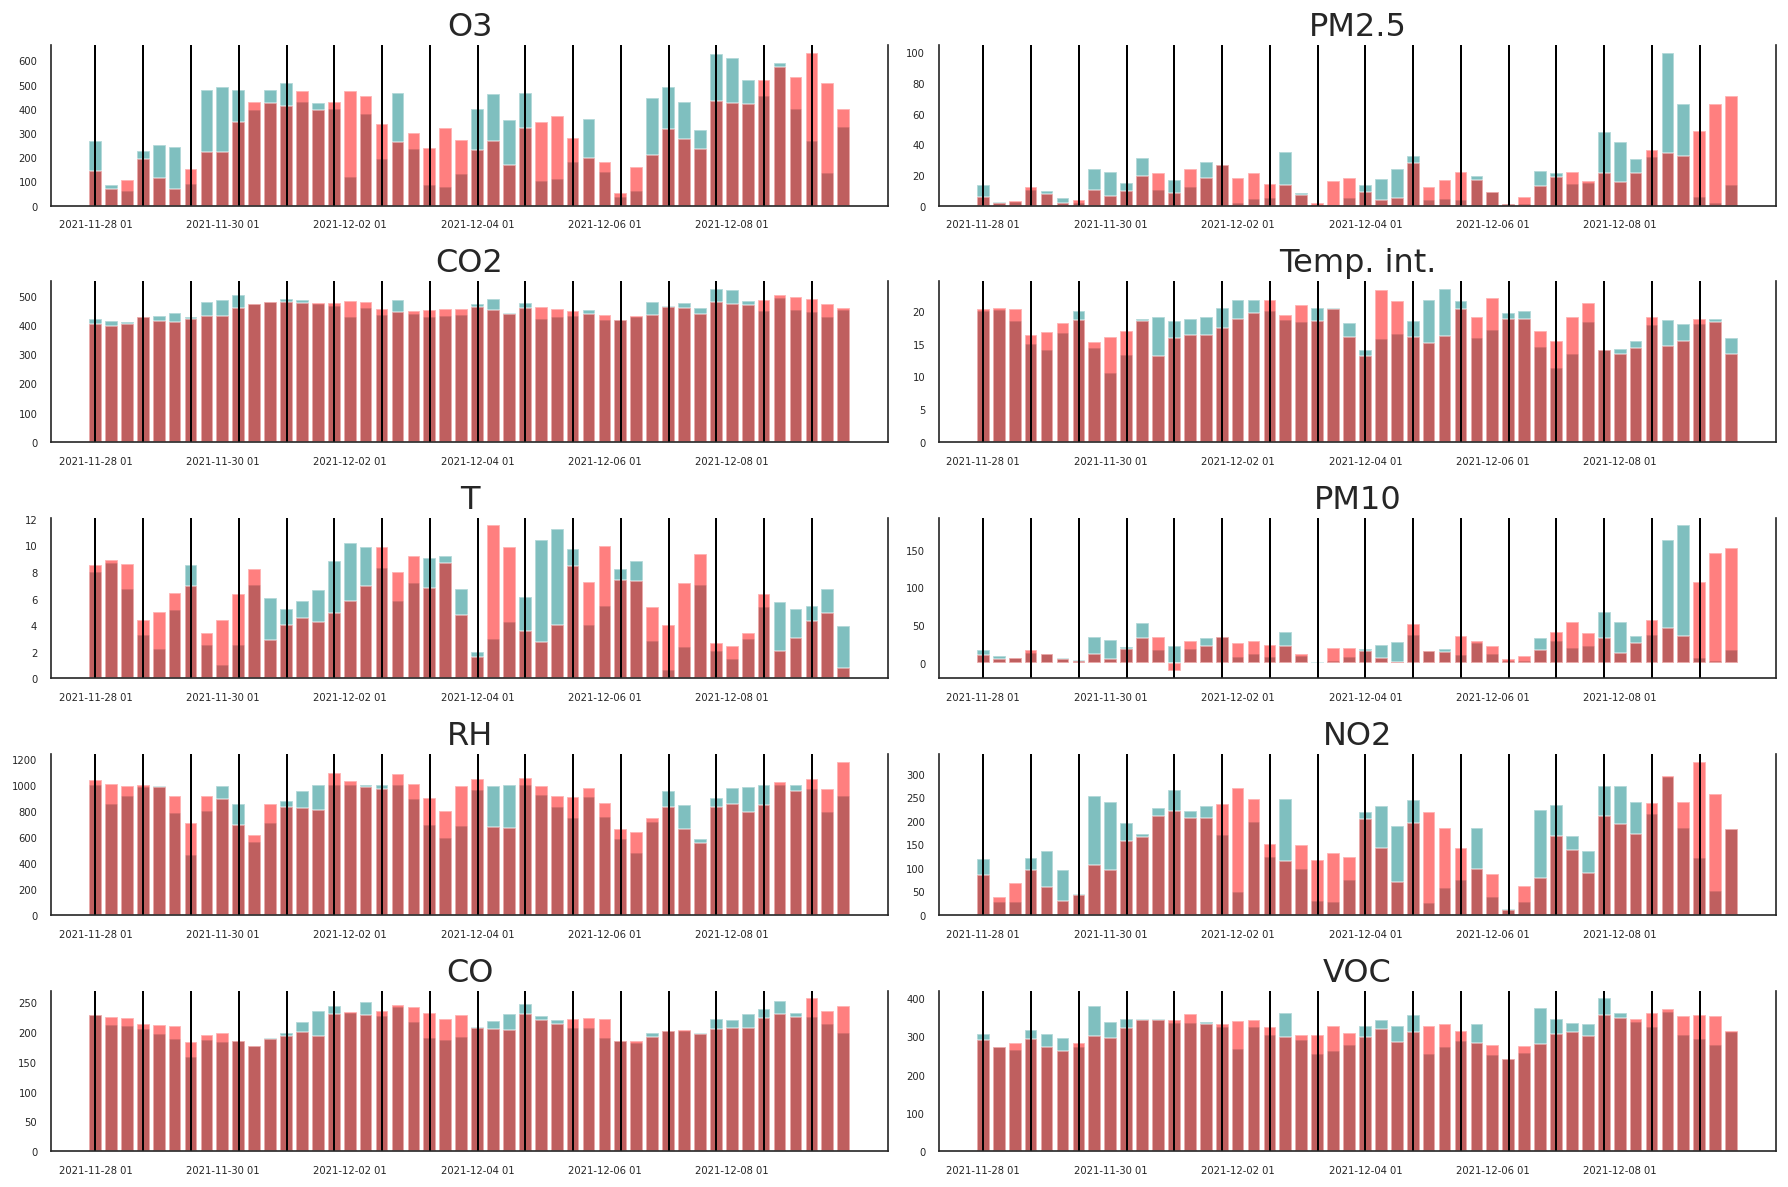

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x_ticks = np.arange(0, to_predict_w, 8)
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(15,10))
plt.setp(axes, xticks=x_ticks)
for i, ax in enumerate(axes.flatten()):
  data_for_w = df_c[df_c.columns[i]].iloc[-to_predict_w:]
  data_res_fc=res_fc[res_fc.columns[i]]
  ax.bar(data_for_w.index, data_for_w, alpha=0.5,color='teal', linewidth=1)
  ax.bar(data_res_fc.index, data_res_fc, alpha=0.5,color='red', linewidth=1)
  for j in range(len(for_index)):
    ax.axvline(for_index[j]	, color='black')
  # Decorations
  ax.set_title(df_copy.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines["top"].set_alpha(0)
  ax.tick_params(labelsize=6)
  ax.set_xticks(x_ticks)

plt.tight_layout();

Forecast accuracy:

In [ ]:
from statsmodels.tsa.stattools import acf
def adjust(val, length= 6): return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    if(all (np.abs(actual))!=0):
      mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
      mpe = np.mean((forecast - actual)/actual)   # MPE
    else: 
    #10 significa che non è calcolabile perchè actual è nullo
      mape=10
      mpe=10
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #mette forecast e actual in 2 colonne parallele (hstack) e trova il minimo/massimo per ogni riga tra le 2 colonne
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    if(all (maxs)!=0):
      minmax = 1 - np.mean(mins/maxs)             # minmax
    else: 
      minmax=10
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  'minmax':minmax})
for col in df_copy.columns:
  print('Forecast Accuracy of: '+col)
  accuracy_prod = forecast_accuracy(res_fc[col].values, df_c[col].iloc[-to_predict_w:])
  for k, v in accuracy_prod.items():
     print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: O3
mape   :  0.6971
me     :  -7.3661
mae    :  138.9286
mpe    :  0.3353
rmse   :  166.777
minmax :  0.3771
Forecast Accuracy of: PM2.5
mape   :  2.8714
me     :  0.072
mae    :  13.4335
mpe    :  2.4164
rmse   :  20.5847
minmax :  0.508
Forecast Accuracy of: CO2
mape   :  0.0486
me     :  -1.7762
mae    :  22.2674
mpe    :  -0.0018
rmse   :  27.6028
minmax :  0.047
Forecast Accuracy of: Temp. int.
mape   :  0.1496
me     :  0.0231
mae    :  2.51
mpe    :  0.0222
rmse   :  3.1475
minmax :  0.1304
Forecast Accuracy of: T
mape   :  0.6785
me     :  0.0419
mae    :  2.4978
mpe    :  0.3441
rmse   :  3.1188
minmax :  0.3568
Forecast Accuracy of: PM10
mape   :  2.5736
me     :  1.6314
mae    :  25.2
mpe    :  2.041
rmse   :  45.0223
minmax :  0.5256
Forecast Accuracy of: RH
mape   :  0.1501
me     :  26.2685
mae    :  119.9338
mpe    :  0.0514
rmse   :  145.0586
minmax :  0.1303
Forecast Accuracy of: NO2
mape   :  0.8948
me     :  0.7809
mae    :  68.8795
mpe    :  0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
